In [228]:
import numpy as np
import datetime as dt
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import matplotlib.colors as cm
from netCDF4 import Dataset
from sys import path
import copy
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
path.insert(0, '/Users/h/Github/geo_data_group/')
# import data_year as dy
### make sure you have: grid_set.py, budget_inputs.py, budget.py
import grid_set as gs
import budget_inputs as bi
import budget_accum as b
from imp import reload
reload(gs)
reload(b)
reload(bi)

<module 'budget_inputs' from '/Users/h/PREMELT/Budget/Budget_tool/budget_inputs.py'>

In [229]:
## f = A - B
## sig_f^2 = sig_A^2 + sig_B^2 - 2 sig_AB

## f = A + B
## sig_f^2 = sig_A^2 + sig_B^2 + 2 sig_AB

## f = AB
## sig_f^2 = f[ (sig_A/A)^2 + (sig_B/B)^2 + 2 sig_AB/AB ]

## SPLIT RIGHT UP TO GET COV VALUES AT ALL STAGES
## deal with sig at all stages (not sig^2)

def sum_sig(A,B,A_sig,B_sig,cor_AB = 0.0):
    
    C = A+B
    
    C_sig2 = A_sig**2 + B_sig**2 \
               + 2*cor_AB*A_sig*B_sig
    
    return C,np.sqrt(C_sig2)

def diff_sig(A,B,A_sig,B_sig,cor_AB = 0.0):
    C = A-B
    
    C_sig2 = A_sig**2 + B_sig**2 \
               - 2*cor_AB*A_sig*B_sig
    
    return C,np.sqrt(C_sig2)

def mult_sig(A,B,A_sig,B_sig,cor_AB = 0.0):
    C = A*B
    
    Asig_norm = A_sig/A
    Bsig_norm = B_sig/B
    
    C_sig2 = C**2*(Asig_norm**2 + Bsig_norm**2 + 2*cor_AB*Asig_norm*Bsig_norm)
             
    return C,np.sqrt(C_sig2)

def grd_V_sig(vol,vol_sig,G,cor_dvdx = 0.97):
    ### replicates : (Vol[1:-1,2:]-Vol[1:-1,:-2])/(2*G.ydist[1:-1,1:-1]))
    signal1,grdv1_sig = diff_sig(vol[2:,1:-1],vol[:-2,1:-1],
                                 vol_sig[2:,1:-1],vol_sig[:-2,1:-1],
                                 cor_AB = cor_dvdx)
    signal2,grdv2_sig = diff_sig(vol[1:-1,2:],vol[1:-1,:-2],
                                 vol_sig[1:-1,2:],vol_sig[1:-1,:-2],
                                 cor_AB = cor_dvdx)
    signal1 = signal1/(2*G.xdist[1:-1,1:-1])
    signal2 = signal2/(2*G.ydist[1:-1,1:-1])
    
    grdv1_sig = grdv1_sig/(2*G.xdist[1:-1,1:-1])
    grdv2_sig = grdv2_sig/(2*G.ydist[1:-1,1:-1])
    
    return signal1,signal2,grdv1_sig,grdv2_sig

def adv_comp_sig(U,V,U_sig,V_sig,
                 grdVol1,grdVol2,grd_Vol1_sig,grd_Vol2_sig,
                 G,cor_sigUgrdV = 0.0):
    ### replicates -V[1:-1,1:-1]*(Vol[1:-1,2:]-Vol[1:-1,:-2])/(2*G.ydist[1:-1,1:-1])
    signal1,adv1_sig = mult_sig(-U[1:-1,1:-1],grdVol1,
                                U_sig[1:-1,1:-1],grd_Vol1_sig,
                                cor_AB=cor_sigUgrdV)
    signal2,adv2_sig = mult_sig(-V[1:-1,1:-1],grdVol2,
                                V_sig[1:-1,1:-1],grd_Vol2_sig,
                                cor_AB=cor_sigUgrdV)
    
    return signal1,signal2,adv1_sig,adv2_sig

def adv_sig(adv1,adv2,adv1_sig,adv2_sig,cor_adv1adv2 = 0.0):
    signal,advsig = sum_sig(adv1,adv2,adv1_sig,adv2_sig,
                             cor_AB=cor_adv1adv2)
    
    return signal,advsig


def div_U_comp_sig(U,V,U_sig,V_sig,G,cor_dUdx = 0.98):

    signal1,divU1_sig = diff_sig(U[2:,1:-1],U[:-2,1:-1],
                                 U_sig[2:,1:-1],U_sig[:-2,1:-1],
                                 cor_AB = cor_dUdx)
    signal2,divU2_sig = diff_sig(V[1:-1,2:],V[1:-1,:-2],
                                 V_sig[1:-1,2:],V_sig[1:-1,:-2],
                                 cor_AB = cor_dUdx)
    
    signal1 = signal1/(2*G.xdist[1:-1,1:-1])
    signal2 = signal2/(2*G.ydist[1:-1,1:-1])
    
    divU1_sig = divU1_sig/(2*G.xdist[1:-1,1:-1])
    divU2_sig = divU2_sig/(2*G.ydist[1:-1,1:-1])
    
    return signal1,signal2,divU1_sig,divU2_sig

def div_U_sig(divU,divV,divU_sig,divV_sig,G,cor_divU12 = 0.0):
    
    signal,divV_tot_sig = sum_sig(-divU,-divV,divU_sig,divV_sig,
                             cor_AB=cor_divU12)
    
    return signal,divV_tot_sig

def div_sig(Vol,Vol_sig,divU,divUsig,cor_VoldivU = 0.0):
    
    signal,divsig = mult_sig(Vol[1:-1,1:-1],divU,
                               Vol_sig[1:-1,1:-1],divUsig,
                               cor_AB=cor_VoldivU)
    
    return signal, divsig

def advection_sig(U,V,vol,Usig,Vsig,volsig,G,
                  cor_dvdx = 0.97,cor_sigUdivV=-0.02):
    ### covariances F2
    grdVol1,grdVol2,grdVol1_sig,grdVol2_sig =  grd_V_sig(
                    vol,volsig,G,cor_dvdx = cor_dvdx)
    ### covariances F3
    adv1,adv2,adv1_sig,adv2_sig = adv_comp_sig(
             U,V,Usig,Vsig,
             grdVol1,grdVol2,grdVol1_sig,grdVol2_sig,
             G,cor_sigUgrdV=cor_sigUdivV)
    ### totals
    totadv,totadv_sig = adv_sig(
             adv1,adv2,adv1_sig,adv2_sig,
             cor_adv1adv2 = 0.0)
    totadv =     np.pad(totadv,    ((1,1),(1,1)),'constant',
                         constant_values = np.nan)
    totadv_sig = np.pad(totadv_sig,((1,1),(1,1)),'constant',
                         constant_values = np.nan)
    return totadv,totadv_sig

def divergence_sig(U,V,vol,Usig,Vsig,volsig,G,
                  cor_dUdx = 0.98,cor_divU12=-0.01):

    ### covariances F2
    divV1,divV2,divV1_sig,divV2_sig =  div_U_comp_sig(
                    U,V,Usig,Vsig,G,
                    cor_dUdx = cor_dUdx)
    ### covariances F3
    divU, divU_sig = div_U_sig(
                divV1,divV2,divV1_sig,divV2_sig,G,
                cor_divU12=cor_divU12)

    ### totals
    totdiv,totdiv_sig = div_sig(vol,volsig,
                                divU,divU_sig)
    totdiv =     np.pad(totdiv,    ((1,1),(1,1)),'constant',
                         constant_values = np.nan)
    totdiv_sig = np.pad(totdiv_sig,((1,1),(1,1)),'constant',
                         constant_values = np.nan)
    return totdiv,totdiv_sig

def intensification_sig(Vols,Vols_sig,nsecs,
                  cor_Volt = 0.998):

    signal1,ints_sig = diff_sig(Vols[2,:,:],Vols[0,:,:],
                                Vols_sig[2,:,:],Vols_sig[0,:,:],
                                cor_AB = cor_Volt)
    tot_int  = signal1/(2*nsecs)
    ints_sig = ints_sig/(2*nsecs)
    
    return tot_int,ints_sig



In [230]:
class accumulator:
    def __init__(self,shape):
        self.count = np.zeros(shape,dtype = int)
        self.data = np.ma.masked_all(shape)
        self.data[:] = 0.0
        self.data.mask[:] = True
        
    def update(self,new_data,mask=None):
        new_mask = np.isnan(new_data)
        if mask is not None:
            new_mask[mask] = True
        self.data.mask[~new_mask] = False
        self.data[~new_mask] += new_data[~new_mask]
        self.count += ~new_mask
    
    def clean(self):
        self.count[:] = 0
        self.data[:] = 0.0
        self.data.mask[:] = True
        
    def mean(self):
        out_array = self.data.data/self.count
        out_array[self.data.mask] = np.nan
        return out_array
        
    def total(self):
        out_array = self.data.data
        out_array[self.data.mask] = np.nan
        return out_array
    
class recent_array:
    """
    list of nlist arrays that can be updated and the mean returned
    give the shape of each array, and the no. of slices to remember
    """
    def __init__(self,shape,nlist):
        self.shape = (nlist,)+shape
        self.nlist = nlist
        self.data = np.zeros(self.shape)*np.nan
    def update(self,array):
        ### push each entry along the list by copying entries
        for n in range(self.nlist-1):
            self.data[n,:] = self.data[n+1,:] 
        self.data[self.nlist-1,:] = array[:]
    def mean(self):
        return np.nanmean(self.data,axis = 0)
    def clean(self):
        for n in range(self.nlist):
            self.data[:] = np.zeros(self.shape)*np.nan
        

In [231]:
### save direcotry, make this somewhere else
# spath = '/home/hds/DATA2/HR_Budgets/Budget_out_2021_08_13/out_ECCC_Bremmen_Bristol_CPOM/'

# ### this makes the directory
# save_dir = os.path.dirname(spath)
# # check it exists
# if not os.path.exists(save_dir):
#     # make if it doesn't
#     os.makedirs(save_dir)
#     print('Creating directory: ',save_dir)
# else: print('Existing directory: ',save_dir)


In [232]:

ts = dt.datetime(2015,1,1)
te = dt.datetime(2016,2,16)
# ts = dt.datetime(2013,8,1)
# te = dt.datetime(2013,9,1)
tw = relativedelta(days = 1)


In [233]:
### First we need grids for the data we're using
## the grids sit with a projection North pole in this case


### ECCC plot options
# lon_lims = [-64,-37,  0]
# lat_lims = [73,79,89.9]
# m= ccrs.Orthographic(lon_lims[1],lat_lims[1])
m = ccrs.NorthPolarStereo()

In [234]:
pole_hole_lat = 87.4
GV = gs.grid_set(m)
GV.load_grid('grids/Pathfinder_gs.npz')
# GV.load_grid('grids/osisaf_455_gs.npz')
# GV.load_mask('grids/Pathfinder_gs_mask.npz')
GV.get_grid_mask()

Loaded a grid: grids/Pathfinder_gs.npz


In [235]:
# GV.inflate_mask(110e3)
GV_for_Tmask = GV.mask.copy()
GV_for_Tmask[GV.lats>pole_hole_lat] = np.nan

In [236]:
# pole_hole_lat = 88.4
GT = gs.grid_set(m)
GT.load_grid('grids/Bristol_nh_80km_gs.npz')
GT.load_mask('grids/Bristol_nh_80km_gs_mask.npz')
# GT.mask[GT.lats>pole_hole_lat] = np.nan

Loaded a grid: grids/Bristol_nh_80km_gs.npz
Loaded mask,  100  x  100  inflated by  0.0


In [237]:
pole_hole_lat = 88.0
GC = gs.grid_set(m)
GC.load_grid('grids/NSIDC_gs.npz')
GC.load_mask('grids/NSIDC_gs_mask.npz')
# GC.inflate_mask(150e3)
# GC.mask[GC.lats>pole_hole_lat] = np.nan
# GC.mask = np.ones_like(GC.lons)

Loaded a grid: grids/NSIDC_gs.npz
Loaded mask,  448  x  304  inflated by  0.0


In [238]:
m = ccrs.NorthPolarStereo()
### Fram strait
Fram = gs.grid_set(m)
### Central_west
Central_west = gs.grid_set(m)
### Central_east
Central_east = gs.grid_set(m)
Gates_list = [
    [Fram,'Gate_Fram/'],
    [Central_east,'Gate_Central_east/'],
    [Central_west,'Gate_Central_west/'],
]
for gl in Gates_list:
    grid_name = gl[1].split('/')[0]+'.npz'
    mask_name = gl[1].split('/')[0]+'_mask.npz'
    gl[0].load_grid('grids/Gate_grids/'+grid_name)
    gl[0].load_mask('grids/Gate_grids/'+mask_name)
    gl.append(gs.Gs2Gs(GV,gl[0],vectors=True))

Loaded a grid: grids/Gate_grids/Gate_Fram.npz
Loaded mask,  33  x  2  inflated by  0.0
Loaded a grid: grids/Gate_grids/Gate_Central_east.npz
Loaded mask,  84  x  2  inflated by  0.0
Loaded a grid: grids/Gate_grids/Gate_Central_west.npz
Loaded mask,  65  x  2  inflated by  0.0


In [240]:
### drift data object
# path = '/home/hds/DATA/ECCC_SIM_PREMELT/'
# path = '/Users/h/PREMELT/Budget/Pathfinder_NRT/'
# P = bi.Pathfinder_weekly(path)
# path = '/Users/h/PREMELT/Budget/Data/Pathfinder/'
# P = bi.Pathfinder(path)
path = '/Users/h/PREMELT/Budget/Data/Pathfinder/arco/'
P = bi.Pathfinder(path)
reload(bi)
# P = bi.OSISAF('../Data/OSISAF_new/',version='455')

P.get_dates(ts,te)

Pathfinder Found 365 dates


In [242]:
# P.fname_455(dt.datetime(2014,10,31))

In [243]:
### THICKNESS
# path = '/home/hds/DATA2/NSIDC/nasa_daily/arco/'
# C = bi.NSIDC_nt(path)
# path = '/home/hds/DATA2/NSIDC/bootstrap_daily/'
# C = bi.NSIDC_bt(path)
path = '/Users/h/PREMELT/Budget/Data/Bristol/80km_seasonal/'
A = bi.Bristol_thickness_seasonal(path)

A.get_dates(ts,te)

Bristol_hi_seasonal Found 236 dates


In [244]:
### CONCENTRATION

# path = '/home/mct/Data/Bristol/Arctic_Daily_Thickness/'
path = '/Users/h/PREMELT/Budget/Data/NSIDC/nasa_daily/arco/'
C = bi.NSIDC_nt(path)

C.get_dates(ts,te)
tsC = dt.datetime(2015,1,1)
teC = dt.datetime(2016,2,16)
C.get_dates(tsC,teC)

NSIDC_n Found 31 dates
NSIDC_n Found 31 dates


In [245]:
## Thickness/Con limit masking
Tlim = 0.2   ### meters below which we mask
Clim = 0.15  ### conc.  below which we mask

In [246]:
### use data to set the dates to process
dlist = b.get_loop_list(P.dates,tw)
ts = dlist[0]
ndays = np.shape(dlist)[0]

made loop list length 365
Start : 20150101
Finish: 20151231


In [247]:
### compare to additional data
# dlist = b.comp_dates(dlist,A.dates)
dlist = b.comp_dates(dlist,C.dates)
ndays = np.shape(dlist)[0]

made loop list length 31
Start : 20150101
Finish: 20150131


In [248]:
ndays
# dlist

31

In [249]:
ndays = (dlist[-1]  - dlist[0] ).days +1
dlist = [dlist[0] + relativedelta(days=d) for d in range(ndays)]
dlist[0]

datetime.datetime(2015, 1, 1, 0, 0)

In [250]:
# ### or a manual list
# dlist = []
# d0 = dt.datetime(2020,3,10)
# [dlist.append(d0+relativedelta(days=d)) for d in range(10) ]
# ts = dlist[0]

In [251]:
# input select
InputV = P # velocity forcing
InputT = A # thickness
InputC = C # concentration

In [252]:
# grid select
Gvel = GV
Gthk = GT
Gcon = GC

In [253]:
### regridders - slow
RGDcon = gs.Gs2Gs(Gcon,Gvel,NaN_avoid=True)

Gs2Gs  input bad point avoidance found  0
Gs2Gs output bad point avoidance found  0


In [254]:
RGDthk = gs.Gs2Gs(Gthk,Gvel,NaN_avoid=True)

Gs2Gs  input bad point avoidance found  0
Gs2Gs output bad point avoidance found  0


In [255]:
# smoothing options
smthvel = False
smththk = False
smthcon = False
Vsmth = lambda x: x
Tsmth = lambda x: x
Csmth = lambda x: x

In [34]:
# smoothing options
smthvel = True
smththk = True
smthcon = True
#### smooothing options
#### old uniform
velsmrad = 5
Vsmth = lambda x: b.smooth2a(x,velsmrad)
thksmrad = 2
Tsmth = lambda x: b.smooth2a(x,thksmrad)
consmrad = 10
Csmth = lambda x: b.smooth2a(x,consmrad)

In [35]:
# #### new vary smoothing
velsmthdist = 150e3
thksmthdist = 100e3
consmthdist = 60e3

VSmthObj = gs.geo_vary_smooth(Gvel,velsmthdist,in_mask = True,verbos=True)
TSmthObj = gs.geo_vary_smooth(Gthk,thksmthdist,in_mask = True,verbos=True)
CSmthObj = gs.geo_vary_smooth(Gcon,consmthdist,in_mask = True,verbos=True)


Bulding vary smoother, av cell dist = [2.0, 2.2], [2.0, 2.2]
Smooth martix, entries = 143916, mean weights = 0.0751
Bulding vary smoother, av cell dist = [1.3, 1.5], [1.3, 1.5]
Smooth martix, entries = 39283, mean weights = 0.1216
Bulding vary smoother, av cell dist = [2.6, 3.1], [2.6, 3.1]
Smooth martix, entries = 1658321, mean weights = 0.0422


In [36]:
smthvel = True
smththk = True
smthcon = True
Vsmth = VSmthObj.smooth
Tsmth = TSmthObj.smooth
Csmth = CSmthObj.smooth

In [320]:
#### here is a place for development - try a guassian smoother
### astropy.convolve is the code to look for

In [256]:
#### history accumulator
budhist = b.budhist(Gvel,dlist,tw,tot_budget=True,split_div=True,save_input=True,
                    dumptw = relativedelta(days=1),budday0=ts)

In [257]:
f = plt.figure()
ax = f.add_subplot(1,1,1,projection=m)
ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
Gplocal= gs.grid_set(m)
Gplocal.set_grid_mn(70,70,ax)
Gplocal.get_grid_info(av_ang=False)
plt.close()
G2Gplocal = gs.Gs2Gs(Gvel,Gplocal,vectors=True)

Got a grid res =  70  x  70
Grid distances calculated:  94073.00962542805  x  93502.42529649287
Angles calculated


In [258]:
[gl[1] for gl in Gates_list]

['Gate_Fram/', 'Gate_Central_east/', 'Gate_Central_west/']

In [259]:
### historys for covariance testing
recent = {}
recent['nr'] = 12
recent_vars = ['int','adv','div','res','u','v','vol']
#### some more for extra covariances in histories
cov_vars = ['int_c','adv_c','res_c','u_c','v_c','vol_c']
trans_vars = ['trans_x','trans_y']
for var in recent_vars+trans_vars:
    recent[var] = recent_array(Gvel.shape,recent['nr'])
    for d in range(1,recent['nr']):
        recent[var+str(d)] = []
for var in cov_vars:
    recent[var] = recent_array(Gvel.shape,recent['nr'])
    for d in range(0,recent['nr']+1):
        recent[var].update(np.zeros(Gvel.shape)*Gvel.mask)
# for gl in Gates_list:
#     recent[gl[1]] = recent_array(gl[0].shape,recent['nr'])
#     for d in range(0,recent['nr']+1):
#         recent[gl[1]].update(np.zeros(gl[0].shape))

In [260]:
hist = {}
### normal terms
hist_vars = ['Vol','U','V','div','adv','int','res','dyn']
### missing T terms (ice edge, thin ice)
hist_vars.extend(['div_t','adv_t','int_t','res_t','dyn_t'])
### new/old ice terms
hist_vars.extend(['new_ice','old_ice'])
### uncertainties
hist_vars.extend(['div_sig','adv_sig','int_sig','res_sig','dyn_sig'])
hist_vars.extend(['trans_x','trans_y','trans_x_sig','trans_y_sig'])
hist_vars.extend(['U_sig','V_sig','Vol_sig'])
for var in hist_vars:
    hist[var] = accumulator(Gvel.shape)
    

In [261]:
## F1 convariants
cor_dVdt = [] 
cor_grdV1 = [] 
cor_grdV2 = [] 
cor_divU1 = []
cor_divU2 = []
## F2 convariants
cor_sigu1grdVol1 = []
cor_sigu2grdVol2 = []
cor_sigdivu1divu2 = []
## totals
cor_adv_div = []
cor_int_div = []
cor_int_adv = []

In [262]:
#### buget is caculated in a rolling way across slices
Uslices = np.empty([3,Gvel.m,Gvel.n])
Vslices = np.empty([3,Gvel.m,Gvel.n])
Tslices = np.empty([3,Gvel.m,Gvel.n])
Cslices = np.empty([3,Gvel.m,Gvel.n])
Vol_slices = np.empty([3,Gvel.m,Gvel.n])

Volerrslices = np.empty([3,Gvel.m,Gvel.n])
Uerrslices = np.empty([3,Gvel.m,Gvel.n])
Verrslices = np.empty([3,Gvel.m,Gvel.n])

# divergence advection are running means so make array
budadv = np.empty([3,Gvel.m,Gvel.n])
buddiv = np.empty([3,Gvel.m,Gvel.n])

In [289]:
load_verbos = True
### initalising the slices
for var in hist_vars:
    hist[var].clean()
for var in recent_vars:
    recent[var].clean()
    for d in range(1,recent['nr']):
        recent[var+str(d)] = []
load_verbos = False

make_eff_thk = True

Utemp,Vtemp = b.get_vels_array(InputV,ts,tw,verbos=load_verbos)
Verrt       =  b.get_err_array(InputV,ts,tw,verbos=load_verbos)
Utemp = Utemp*Gvel.mask
Vtemp = Vtemp*Gvel.mask
if smthvel:
    Uslices[0] = Vsmth(Utemp)
    Vslices[0] = Vsmth(Vtemp)
else:
    Uslices[0] = Utemp
    Vslices[0] = Vtemp
# Verrt = Verrt.data*Gvel.mask/np.sqrt(np.hypot(Utemp,Vtemp))

/opt/miniconda3/envs/harry/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/Users/h/PREMELT/Budget/Budget_tool/budget_accum.py:431: RuntimeWarning: Mean of empty slice
  err_out = np.nanmean(err_in,axis=0)


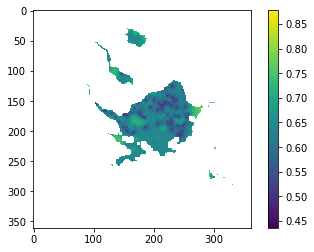

In [288]:
# plt.imshow(np.sqrt(Verrt)*Uslices[0]/np.sqrt(np.hypot(Utemp,Vtemp)),cmap='RdBu')
plt.imshow(np.sqrt(Verrt))#/np.sqrt(np.hypot(Utemp,Vtemp)))
plt.colorbar()

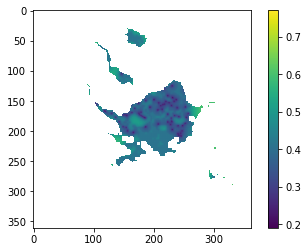

In [287]:
# plt.imshow(Verrt*Uslices[0],cmap='RdBu')
plt.imshow(Verrt)
plt.colorbar()

In [290]:
# Verrt = Verrt/np.hypot(Utemp,Vtemp) ## non-dim verrr
### Verr is non-dim, so we mult out (sorry not generalised)
Uerrslices[0] = Utemp*Verrt
Verrslices[0] = Vtemp*Verrt
Ttemp =  b.get_hi_array(InputT,ts,tw,verbos=load_verbos)
Terrt = b.get_err_array(InputT,ts,tw,verbos=load_verbos)
Ttemp[Ttemp <Tlim] = np.nan
Terrt[Ttemp <Tlim] = np.nan
Ttemp = Ttemp*Gthk.mask
Terrt = Terrt*Gthk.mask
if smththk:
    Ttemp = Tsmth(Ttemp)
else:
    Ttemp = Ttemp
# call the regrid object
Ttemp = RGDthk.rg_array(Ttemp)
Terrt = RGDthk.rg_array(Terrt)
Ttemp = Ttemp*GV_for_Tmask
Terrt = Terrt*GV_for_Tmask

# Tslices[0] = Ttemp

# Ctemp= b.get_aice_array(InputC,ts,tw,verbos=load_verbos)
# Ctemp[Ctemp <Clim] = np.nan
# Ctemp = Ctemp*Gcon.mask
# if smthcon:
#     Ctemp = Csmth(Ctemp)
# else:
#     Ctemp = Ctemp
# # call the regrid object
# Ctemp = RGDcon.rg_array(Ctemp)
Ctemp = np.zeros_like(Gvel.mask)
Ctemp[np.isfinite(Gvel.mask)] = 0.998
Ctemp = Ctemp*Gvel.mask
Cslices[0] = Ctemp


#### we need to set all open ocean volume to 0.0,
#### all land points to np.nan - use a grid mask
# if not cut_new_ice:
#     Vol_slices[0][np.isnan(Vol_slices[0])] = 0.0
#     Vol_slices[0] *=Gvel.mask

### All the neccessary masking and extras
IsIce = Ctemp>0.15
Tmask = Ttemp>0.2#*np.isfinite(Tmask)
Vmask = np.isfinite(Vtemp)
Thin_mask = IsIce^Tmask
Miss_mask = IsIce^Vmask
#### force more data
Ttemp[Thin_mask] = 0.2

Tslices[0] = Ttemp
if make_eff_thk:
    Vol_slices[0] = Tslices[0]*Cslices[0]
else:
    Vol_slices[0] = Tslices[0]
Volerrslices[0] = Terrt
    

Uslices[1],Vslices[1] = Uslices[0],Vslices[0]
Uerrslices[1] = Uerrslices[0]
Verrslices[1] = Verrslices[0]
Tslices[1] = Tslices[0]
Cslices[1] = Cslices[0]
Vol_slices[1] = Vol_slices[0]
Volerrslices[1] = Volerrslices[0]

#### adv & div at single points
# advection and divergence are calculated slice by slice
# so do it as we load
# ADVECTION
advtemp = b.advection(Uslices[0],Vslices[0],Vol_slices[0],Gvel)
budadv[0] = advtemp

# DIVERGENCE
divtemp = b.divergence(Uslices[0],Vslices[0],Vol_slices[0],Gvel)
buddiv[0] = divtemp

budadv[1] = budadv[0]
buddiv[1] = buddiv[0]

### accumulate the normal Tmask terms, +Thin_mask terms, Miss mask???
### accumulate new_ice and gone ice
# 
# prev_int_sig = np.zeros(Gvel.shape)
# prev_adv_sig = np.zeros(Gvel.shape)

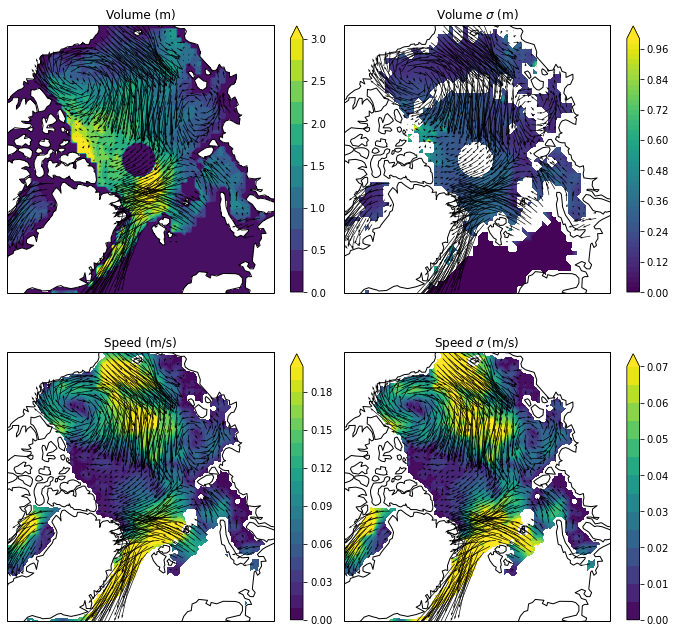

In [291]:
vsc = 1.3
points = [[-30,75],[120,75],[0,90]] ## central barents
# points = [[0,75],[60,75],[0,86]] ### zoom barents edge #### force map to include these points
# points = [[-175,72],[-140,68],[-160,86]] ## Beaufort ish
lims = GV.lims_from_lonlat(points,for_extent = True)
level_list = [
    np.arange(0,3.25,0.25),
    np.arange(0,1.02,0.02),
    np.arange(0,0.21,0.01),
    np.arange(0,0.075,0.005),
#     np.arange(0,3.25,0.25),
#     np.arange(0,1.45,0.05),
#     np.arange(0,0.16,0.01),
# #     np.arange(0,0.055,0.005),
#     np.arange(0,0.11,0.01),
]
arr_list = [
    Vol_slices[1],
    Volerrslices[1],
    np.hypot(Uslices[1],Vslices[1]),
    np.hypot(Uerrslices[1],Verrslices[1]),
#     Uerrslices[1],
#     hist['Vol'].mean(),
#     np.sqrt(hist['Vol_sig'].mean()),
#     np.hypot(hist['U'].mean(),hist['V'].mean()),
#     np.sqrt(np.hypot(hist['U_sig'].mean(),hist['V_sig'].mean()))
]
cmap_list = [
    plt.cm.viridis
]*4
lab_list = ['Volume (m)','Volume $\sigma$ (m)',
           'Speed (m/s)','Speed $\sigma$ (m/s)'
           ]
xv,yv = G2Gplocal.rg_vecs(Uslices[1],Vslices[1])
# xv,yv = G2Gplocal.rg_vecs(hist['U'].mean(),hist['V'].mean())
#### plot concentration (vel grid)
f = plt.figure(figsize=( 12,12))
for ns,(arr,levels,cmap,lab) in enumerate(zip(arr_list,level_list,cmap_list,lab_list)):
    ax = f.add_subplot(2,2,ns+1,projection=m)
#     ax.set_extent(lims,m)
    ax.set_extent([-180, 180, 70, 90], ccrs.PlateCarree())
    # s = ax.contourf(Gthk.xpts,Gthk.ypts,Tslices[0],levels = levels)
    s = ax.contourf(GV.xpts,GV.ypts,arr,levels = levels,
                    cmap = cmap,extend='max')
    ax.quiver(Gplocal.xpts,Gplocal.ypts,xv,yv,scale = vsc)
    ax.add_feature(cfeature.COASTLINE)
    plt.colorbar(s,shrink=0.82)
    ax.set_title(lab)
    

plt.subplots_adjust(wspace=0.01,hspace=0.01)
plt.show()
# f.savefig(fig_dir+'Inputs_single_day.png',bbox_inches='tight')

In [180]:
#### looooop
load_verbos=False
### Now loop along the list of dates
for n,d in enumerate(dlist[1:]):
    print("new slice from "+d.strftime('%Y%m%d'))
    # update final slice
    
    Utemp,Vtemp = b.get_vels_array(InputV,d,tw,verbos=load_verbos)
    Verrt= b.get_err_array(InputV,d,tw,verbos=load_verbos)
    Utemp = Utemp*Gvel.mask
    Vtemp = Vtemp*Gvel.mask
    if smthvel:
        Utemp = Vsmth(Utemp)
        Vtemp = Vsmth(Vtemp)
    Verrt = Verrt/np.hypot(Utemp,Vtemp) ## non-dim verrr
    Verrt = Verrt.data*Gvel.mask
    Uslices[2] = Utemp
    Vslices[2] = Vtemp
    Uerrslices[2] = Utemp*Verrt
    Verrslices[2] = Vtemp*Verrt
    
    Ttemp= b.get_hi_array(InputT,d,tw,verbos=load_verbos)
    Terrt= b.get_err_array(InputT,d,tw,verbos=load_verbos)
    Ttemp[Ttemp <Tlim] = np.nan
    Terrt[Ttemp <Tlim] = np.nan
    Ttemp = Ttemp*Gthk.mask
    Terrt = Terrt*Gthk.mask
    if smththk:
        Ttemp = Tsmth(Ttemp)
    # call the regrid object
    Ttemp = RGDthk.rg_array(Ttemp)
    Terrt = RGDthk.rg_array(Terrt)
    Ttemp = Ttemp*GV_for_Tmask
    Terrt = Terrt*GV_for_Tmask
    
#     Ctemp= b.get_aice_array(InputC,d,tw,verbos=load_verbos)
#     Ctemp[Ctemp <Clim] = np.nan
#     Ctemp = Ctemp*Gcon.mask
#     if smthcon:
#         Ctemp = Csmth(Ctemp)
#     # call the regrid object
#     Ctemp = RGDcon.rg_array(Ctemp)
    Ctemp = np.zeros_like(Gvel.mask)
    Ctemp[np.isfinite(Gvel.mask)] = 0.998
    Ctemp = Ctemp*Gvel.mask
    Cslices[2] = Ctemp
    
    ### All the neccessary masking and extras
    IsIce = Ctemp>0.15
    Tmask = Ttemp>0.2#*np.isfinite(Tmask)
    Vmask = np.isfinite(Vtemp)
    Thin_mask = IsIce^Tmask
    Miss_mask = IsIce^Vmask
    #### force more data
    Ttemp[Thin_mask] = 0.2

    Tslices[2] = Ttemp

    ### actual budget
    if make_eff_thk:
        Vol_slices[2] = Tslices[2]*Cslices[2]
    else:
        Vol_slices[2] = Tslices[2]
    Volerrslices[2] = Terrt
        
    #### we need to set all open ocea volume to 0.0,
    #### all land points to np.nan - use a grid mask
#     if not cut_new_ice:
#         Vol_slices[2][np.isnan(Vol_slices[2])] = 0.0
#         Vol_slices[2] *=Gvel.mask

        
    # advection and divergence are calculated slice by slice
    # so do it as we load
    # ADVECTION
    advtemp = b.advection(Uslices[2],Vslices[2],Vol_slices[2],Gvel)
    budadv[2] = advtemp

    # DIVERGENCE
    divtemp = b.divergence(Uslices[2],Vslices[2],Vol_slices[2],Gvel)
    buddiv[2] = divtemp

#     print(np.nanmean(buddif))
    # we also need to smooth the div and adv over 3 time steps
    buddiv3 = np.nanmean(buddiv,axis=0)
    budadv3 = np.nanmean(budadv,axis=0)
    
    # CHANGE IN VOL USES ALL SLICES    
    nsecs = b.get_step_size(d,tw)
    buddif=b.intensification(Vol_slices,nsecs)
    
#     hist_vars = ['vol','U','V','dif','adv','int','res',]
    hist['Vol'].update(Vol_slices[1])
    hist['U'].update(Uslices[1])
    hist['V'].update(Vslices[1])
    ### normal terms
    hist['div'].update(buddiv3,mask = ~Tmask)
    hist['adv'].update(budadv3,mask = ~Tmask)
    hist['int'].update(buddif,mask = ~Tmask)
    hist['res'].update(buddif-buddiv3-budadv3,mask = ~Tmask)
    hist['dyn'].update(buddiv3+budadv3,mask = ~Tmask)
    ### ice edge terms
    hist['div_t'].update(buddiv3,mask = ~Thin_mask)
    hist['adv_t'].update(budadv3,mask = ~Thin_mask)
    hist['int_t'].update(buddif,mask = ~Thin_mask)
    hist['res_t'].update(buddif-buddiv3-budadv3,mask = ~Thin_mask)
    hist['dyn_t'].update(buddiv3+budadv3,mask = ~Thin_mask)
    ### new/old ice
    hist['new_ice'].update(np.isnan(Vol_slices[0])*Vol_slices[1]/nsecs)
    hist['old_ice'].update(-1.0*np.isnan(Vol_slices[1])*Vol_slices[0]/nsecs)
    
    ### covariances F1
    tstep = 1
    x,y = Tslices[2-tstep],Tslices[2]
    xymask = np.logical_and(x>0.2,y>0.2)
    cor_dVdt.append(np.corrcoef(x[xymask],y[xymask])[0][1])
    
    dstep = 2
    x,y = Vol_slices[1,1:-1,dstep:], Vol_slices[1,1:-1,:-dstep]
    xymask = np.logical_and(x>0.2,y>0.2)
    cor_grdV1.append(np.corrcoef(x[xymask],y[xymask])[0][1])
    
    x,y = Vol_slices[1,dstep:,1:-1], Vol_slices[1,:-dstep,1:-1]
    xymask = np.logical_and(x>0.2,y>0.2)
    cor_grdV2.append(np.corrcoef(x[xymask],y[xymask])[0][1])
    
    x,y = Vslices[1,1:-1,dstep:], Vslices[1,1:-1,:-dstep]
    xymask = np.logical_and(x<0.2,y<0.2)
    cor_divU1.append(np.corrcoef(x[xymask],y[xymask])[0][1])
    
    x,y = Uslices[1,dstep:,1:-1], Uslices[1,:-dstep,1:-1]
    xymask = np.logical_and(x<0.2,y<0.2)
    cor_divU2.append(np.corrcoef(x[xymask],y[xymask])[0][1])
    
    ### covariances F2
    grdVol1,grdVol2,grdVol1_sig,grdVol2_sig =  grd_V_sig(
                    Vol_slices[1],Volerrslices[1],Gvel)
    
    divV1,divV2,divV1_sig,divV2_sig =  div_U_comp_sig(
                    Uslices[1],Vslices[1],
                    Uerrslices[1],Verrslices[1],Gvel)
    x = Uslices[1,1:-1,1:-1]
    y = grdVol1
    xymask = np.logical_and(np.isfinite(x),np.isfinite(y))
    cor_sigu1grdVol1.append(np.corrcoef(x[xymask],y[xymask])[0][1])
    x = Vslices[1,1:-1,1:-1]
    y = grdVol2
    xymask = np.logical_and(np.isfinite(x),np.isfinite(y))
    cor_sigu2grdVol2.append(np.corrcoef(x[xymask],y[xymask])[0][1])
    x = divV1[1:-1,1:-1]
    y = divV2[1:-1,1:-1]
    xymask = np.logical_and(np.isfinite(x),np.isfinite(y))
    cor_sigdivu1divu2.append(np.corrcoef(x[xymask],y[xymask])[0][1])
    
    ### covariances F3
    adv1,adv2,adv1_sig,adv2_sig = adv_comp_sig(
                 Uslices[1],Vslices[1],Uerrslices[1],Verrslices[1],
                 grdVol1,grdVol2,grdVol1_sig,grdVol2_sig,
                 Gvel)
    divU, divU_sig = div_U_sig(
                 divV1,divV2,divV1_sig,divV2_sig,Gvel)

    inttemp,int_sig = b.intensification_sig(Vol_slices,Volerrslices,
                            #### add for smooth covs
                            cor_Volt = 0.998,
                            nsecs = nsecs)
    advtemp,advsig = b.advection_sig(Uslices[1],Vslices[1],Vol_slices[1],
                                    Uerrslices[1],Verrslices[1],Volerrslices[1],
                            #### add for smooth covs
                            cor_dvdx = 0.998,
                            cor_sigUdivV=0.028,
                            cor_adv1adv2 = -0.2,
                            G=Gvel)

    divtemp,divsig = b.divergence_sig(Uslices[1],Vslices[1],Vol_slices[1],
                                    Uerrslices[1],Verrslices[1],Volerrslices[1],
                            #### add for smooth covs
                            cor_dUdx = 0.995,
                            cor_divU12=-0.3,
                            G=Gvel)
    ### update recent arrays
    recent['int'].update(inttemp)
    recent['adv'].update(advtemp)
    recent['div'].update(divtemp)
#     recent['res'].update(buddif-buddiv3-budadv3)
#     recent['U'].update(Utemp)
#     recent['V'].update(Vtemp)
#     Tcheck = Ttemp.copy()
#     Tcheck[Thin_mask] = np.nan
#     recent['Vol'].update(Tcheck)
    ### correlate the recent arrays
    for var in recent_vars:
        for dn in range(1,np.minimum(n,recent['nr'])):
            x = recent[var].data[recent['nr']-dn-1]
            y = recent[var].data[-1]
            xymask = np.logical_and(np.isfinite(x),np.isfinite(y))
            recent[var+str(dn)].append(np.corrcoef(x[xymask],y[xymask])[0][1])
    ### SANITY CHECK....
#     hist['div'].update(divtemp,mask = ~Tmask)
#     hist['adv'].update(advtemp,mask = ~Tmask)
#     hist['int'].update(inttemp,mask = ~Tmask)
#     hist['res'].update(inttemp-divtemp-advtemp,mask = ~Tmask)
#     hist['dyn'].update(divtemp+advtemp,mask = ~Tmask)
    int_adv_cov = 0.08
    res_sig2 = int_sig**2 + advsig**2 + divsig**2 \
             - 2*int_adv_cov*int_sig*advsig
    ressig = np.sqrt(res_sig2)
    
    #### estimated covariances for previous n_days values
#     cor_intint = [0.6,0.1,0.1,0.1,0.1]
#     cor_advadv = [0.7,0.5,0.4,0.4,0.3]
#     cor_resres = [0.8,0.6,0.4,0.4,0.3]
    cor_intint = 0.6
    cor_advadv = 0.7
    cor_resres = 0.8
    cor_uu = 0.6
    cor_volvol = 0.95
    #### sum up all the covariances over the n_days
    int_cov_sum = np.zeros(Gvel.shape)
    adv_cov_sum = np.zeros(Gvel.shape)
    res_cov_sum = np.zeros(Gvel.shape)
    u_cov_sum = np.zeros(Gvel.shape)
    v_cov_sum = np.zeros(Gvel.shape)
    vol_cov_sum = np.zeros(Gvel.shape)
#     for d,dcov in zip(range(0,recent['nr']),cor_intint):
#         int_cov_sum += recent['int_c'].data[recent['nr']-d-1]*dcov*int_sig
#     for d,dcov in zip(range(0,recent['nr']),cor_advadv):
#         adv_cov_sum += recent['adv_c'].data[recent['nr']-d-1]*dcov*advsig
#     for d,dcov in zip(range(0,recent['nr']),cor_advadv):
#         res_cov_sum += recent['res_c'].data[recent['nr']-d-1]*dcov*ressig
    for dc in range(recent['nr']):
        int_cov_sum += recent['int_c'].data[recent['nr']-dc-1]*cor_intint**(dc+1)*int_sig
        adv_cov_sum += recent['adv_c'].data[recent['nr']-dc-1]*cor_advadv**(dc+1)*advsig
        res_cov_sum += recent['res_c'].data[recent['nr']-dc-1]*cor_resres**(dc+1)*ressig
        u_cov_sum += recent['u_c'].data[recent['nr']-dc-1]*cor_uu**(dc+1)*Uerrslices[1]
        v_cov_sum += recent['v_c'].data[recent['nr']-dc-1]*cor_uu**(dc+1)*Verrslices[1]
        vol_cov_sum += recent['vol_c'].data[recent['nr']-dc-1]*cor_volvol**(dc+1)*Volerrslices[1]
    
    int_sig_tot2= int_sig**2 + 2*int_cov_sum
    adv_sig_tot2= advsig**2 + 2*adv_cov_sum
    res_sig_tot2= res_sig2 + 2*res_cov_sum
    ### sqrting because we need int->adv cov
    int_sig_tot = np.sqrt(int_sig_tot2)
    adv_sig_tot = np.sqrt(adv_sig_tot2)
    div_sig_tot2= divsig**2 
    
#     hist['int_sig'].update(int_sig**2 + 2*cor_intint*int_sig*prev_int_sig)
#     hist['adv_sig'].update(advsig**2  + 2*cor_advadv*advsig*prev_adv_sig)
    hist['int_sig'].update(int_sig_tot2)
    hist['adv_sig'].update(adv_sig_tot2)
    hist['div_sig'].update(div_sig_tot2)
#     res_sig2 = int_sig_tot2 + adv_sig_tot2 + div_sig_tot2 \
#              - 2*int_adv_cov*int_sig_tot*adv_sig_tot
    hist['res_sig'].update(res_sig2)
    dyn_sig2 = adv_sig_tot2 + div_sig_tot2 
    hist['dyn_sig'].update(dyn_sig2)
    hist['U_sig'].update(Uerrslices[1]**2 + 2*u_cov_sum)
    hist['V_sig'].update(Verrslices[1]**2 + 2*v_cov_sum)
    hist['Vol_sig'].update(Volerrslices[1]**2 + 2*vol_cov_sum)
    #### need to add all the covariances for int and adv
    recent['int_c'].update(int_sig)
    recent['adv_c'].update(advsig)
    recent['res_c'].update(ressig)
    recent['u_c'].update(Uerrslices[1])
    recent['v_c'].update(Verrslices[1])
    recent['vol_c'].update(Volerrslices[1])
#     prev_int_sig[:] = int_sig
#     prev_adv_sig[:] = advsig
    #### accumulate transport
    ### ['trans_x','trans_y','trans_x_sig','trans_y_sig']
    transx,transx_sig= b.mult_sig(Vol_slices[1],Uslices[1],Volerrslices[1],Uerrslices[1])
    transy,transy_sig= b.mult_sig(Vol_slices[1],Vslices[1],Volerrslices[1],Verrslices[1])
    hist['trans_x'].update(transx)
    hist['trans_y'].update(transy)
    recent['trans_x'].update(transx_sig)
    recent['trans_y'].update(transy_sig)
    ### transport covariance
#     cor_trans = [0.55,0.3,0.2,0.2,0.2]
    cor_trans = 0.55
    transx_cov_sum = np.zeros(Gvel.shape)
    transy_cov_sum = np.zeros(Gvel.shape)
#     for d,dcov in zip(range(0,recent['nr']),cor_trans):
#         transx_cov_sum += recent['trans_x'].data[recent['nr']-d-1]*dcov*transx_sig
#         transy_cov_sum += recent['trans_y'].data[recent['nr']-d-1]*dcov*transy_sig
    for dc in range(recent['nr']):
        transx_cov_sum  += recent['trans_x'].data[recent['nr']-dc-1]*cor_trans**(dc+1)*transx_sig
        transy_cov_sum  += recent['trans_y'].data[recent['nr']-dc-1]*cor_trans**(dc+1)*transy_sig
    hist['trans_x_sig'].update(transx_sig**2 + 2*transx_cov_sum)
    hist['trans_y_sig'].update(transy_sig**2 + 2*transy_cov_sum)
    for var in trans_vars:
        for dn in range(1,np.minimum(n,recent['nr'])):
            x = recent[var].data[recent['nr']-dn-1]
            y = recent[var].data[-1]
            xymask = np.logical_and(np.isfinite(x),np.isfinite(y))
            recent[var+str(dn)].append(np.corrcoef(x[xymask],y[xymask])[0][1])
    
    
    ### need to check if there is any covariance between:
    ### div and adv
    x = divtemp
    y = advtemp
    xymask = np.logical_and(np.isfinite(x),np.isfinite(y))
    cor_adv_div.append(np.corrcoef(x[xymask],y[xymask])[0][1])
    ### int and dyamics...
    x = inttemp
    y = divtemp
    xymask = np.logical_and(np.isfinite(x),np.isfinite(y))
    cor_int_div.append(np.corrcoef(x[xymask],y[xymask])[0][1])
    x = inttemp
    y = advtemp
    xymask = np.logical_and(np.isfinite(x),np.isfinite(y))
    cor_int_adv.append(np.corrcoef(x[xymask],y[xymask])[0][1])
    
     # update slices
    Uslices[0] = Uslices[1]
    Uslices[1] = Uslices[2]
    Vslices[0] = Vslices[1]
    Vslices[1] = Vslices[2]
    
    Uerrslices[0] = Uerrslices[1]
    Uerrslices[1] = Uerrslices[2]
    Verrslices[0] = Verrslices[1]
    Verrslices[1] = Verrslices[2]
    
    Tslices[0] = Tslices[1]
    Tslices[1] = Tslices[2]
    Cslices[0] = Cslices[1]
    Cslices[1] = Cslices[2]
    
    Vol_slices[0] = Vol_slices[1]
    Vol_slices[1] = Vol_slices[2]
    
    Volerrslices[0] = Volerrslices[1]
    Volerrslices[1] = Volerrslices[2]
    
    budadv[0] = budadv[1]
    budadv[1] = budadv[2]
    
    buddiv[0] = buddiv[1]
    buddiv[1] = buddiv[2]

new slice from 20130801
new slice from 20130802
new slice from 20130803
new slice from 20130804


/Users/h/.local/lib/python3.6/site-packages/ipykernel_launcher.py:85: RuntimeWarning: Mean of empty slice
/Users/h/.local/lib/python3.6/site-packages/ipykernel_launcher.py:86: RuntimeWarning: Mean of empty slice
/Users/h/.local/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
/Users/h/.local/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/Users/h/PREMELT/Budget/Budget_tool/budget_accum.py:65: RuntimeWarning: divide by zero encountered in true_divide
  Bsig_norm = B_sig/B
/Users/h/PREMELT/Budget/Budget_tool/budget_accum.py:65: RuntimeWarning: invalid value encountered in true_divide
  Bsig_norm = B_sig/B
/opt/miniconda3/envs/harry/lib/python3.6/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/miniconda3/envs/harry/lib/python3.6/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value enco

new slice from 20130805
new slice from 20130806
new slice from 20130807
new slice from 20130808


/Users/h/.local/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in multiply
/Users/h/PREMELT/Budget/Budget_tool/budget_accum.py:67: RuntimeWarning: invalid value encountered in add
  C_sig2 = C**2*(Asig_norm**2 + Bsig_norm**2 + 2*cor_AB*Asig_norm*Bsig_norm)
/Users/h/PREMELT/Budget/Budget_tool/budget_accum.py:67: RuntimeWarning: invalid value encountered in multiply
  C_sig2 = C**2*(Asig_norm**2 + Bsig_norm**2 + 2*cor_AB*Asig_norm*Bsig_norm)


new slice from 20130809
new slice from 20130810
new slice from 20130811
new slice from 20130812


/Users/h/PREMELT/Budget/Budget_tool/budget_accum.py:371: RuntimeWarning: Mean of empty slice
  hi_out = np.nanmean(hi_in,axis=0)


new slice from 20130813
new slice from 20130814
new slice from 20130815
new slice from 20130816
new slice from 20130817
new slice from 20130818
new slice from 20130819
new slice from 20130820
new slice from 20130821
new slice from 20130822
new slice from 20130823
new slice from 20130824
new slice from 20130825
new slice from 20130826
new slice from 20130827
new slice from 20130828
new slice from 20130829


In [ ]:
# for var in ['trans_x','trans_y']:
# for var in ['int','adv','div','res']:
for var in ['u_c','v_c','vol_c']:
    for dn in range(1,np.minimum(n,recent['nr'])):
        plt.hist(recent[var+str(dn)],label=var+str(dn),bins=15,alpha=0.5)
    plt.legend()
    plt.title(var)
    plt.show()
    print(np.mean(recent[var+'1']))
    print(np.mean(recent[var+'2']))
    print(np.mean(recent[var+'3']))
    print(np.mean(recent[var+'4']))
    print(np.mean(recent[var+'5']))

In [616]:
### covariances F2
divVol1,divVol2,divVol1_sig,divVol2_sig =  b.grd_V_sig(
                    Vol_slices[1],Volerrslices[1],Gvel,cor_dvdx = 0.998)
grdV1,grdV2,grdV1_sig,grdV2_sig =  b.div_U_comp_sig(
                    Uslices[1],Vslices[1],
                    Uerrslices[1],Verrslices[1],Gvel)
### covariances F3
adv1,adv2,adv1_sig,adv2_sig = b.adv_comp_sig(
             Uslices[1],Vslices[1],Uerrslices[1],Verrslices[1],
             divVol1,divVol2,divVol1_sig,divVol2_sig,
             Gvel,cor_sigUgrdV=-0.02)
grdU, grdU_sig = b.div_U_sig(
             grdV1,grdV2,grdV1_sig,grdV2_sig,Gvel,cor_divU12=-0.00)

### totals
totadv,totadv_sig = b.adv_sig(adv1,adv2,adv1_sig,adv2_sig,cor_adv1adv2 = 0.0)

totdiv,totdiv_sig = b.div_sig(Vol_slices[1],Volerrslices[1],
                            grdU,grdU_sig)



In [119]:
def check_sig(signals,errs,minmax):
    f,axs=plt.subplots(1,3,figsize=[9,3])
    ymax = [[0.0],[0.0]]
    for sig,err in zip(signals,errs):
        cnt,vec = np.histogram(sig[np.isfinite(sig)],range=[-minmax,minmax],bins=100)
        ymax[0] = np.maximum(ymax[0],np.percentile(cnt,[99])*1.5)
        axs[0].plot(vec[1:],cnt)
        axs[0].set_title('Signals')
        axs[0].set_ylim([0.0,ymax[0]])

        msk = np.logical_and(np.isfinite(sig),np.isfinite(err))
        cnt,vec = np.histogram(err[msk],range=[0,minmax],bins=100)
        ymax[1] = np.maximum(ymax[1],np.percentile(cnt,[99])*1.5)
        axs[1].plot(vec[1:],cnt)
        axs[1].set_title('Stds')
        axs[1].set_ylim([0.0,ymax[1]])

        cnt,vec = np.histogram(err[msk]/sig[msk],range=[0,2.0],bins=100)
        axs[2].plot(vec[1:],cnt)
        axs[2].set_title('Relative err.')

    f.show()

/Users/h/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


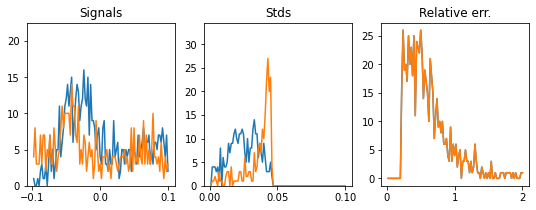

In [120]:
check_sig([Uslices[1],Vslices[1]],[Uerrslices[1],Verrslices[1]],1e-1)

/Users/h/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/Users/h/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/Users/h/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/Users/h/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/Users/h/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


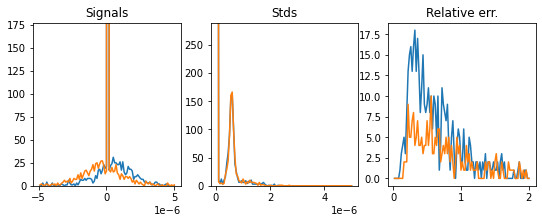

In [122]:
check_sig([grdVol1,grdVol2],[grdVol1_sig,grdVol2_sig],minmax = 5e-6)

/Users/h/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


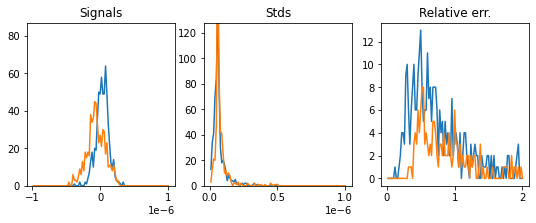

In [123]:
check_sig([divV1,divV2],[divV1_sig,divV2_sig],minmax = 1e-6)

/Users/h/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


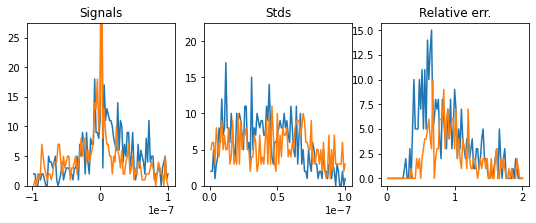

In [124]:
check_sig([adv1,adv2],[adv1_sig,adv2_sig],minmax = 1e-7)

/Users/h/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


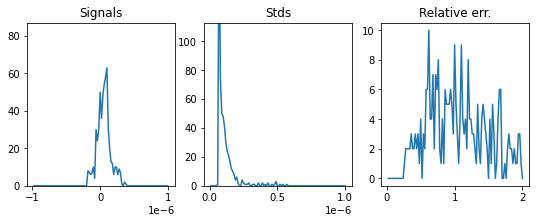

In [125]:
check_sig([divU],[divU_sig],minmax = 1e-6)

In [ ]:
check_sig([totadv],[totadv_sig],minmax = 1e-6)

In [ ]:
check_sig([totdiv],[totdiv_sig],minmax = 1e-6)

/Users/h/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/Users/h/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/Users/h/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


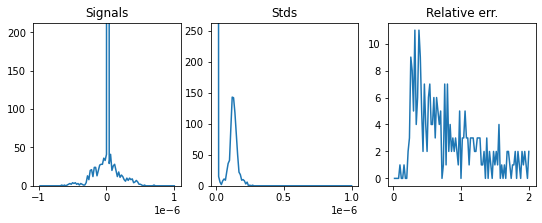

In [126]:
check_sig([inttemp],[int_sig],minmax = 1e-6)

/Users/h/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


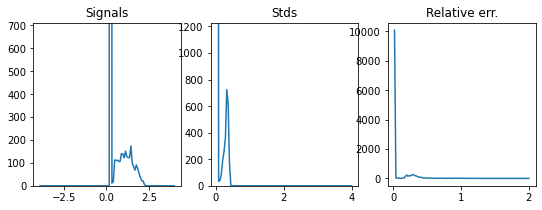

In [127]:
check_sig([Vol_slices],[Volerrslices],minmax = 4e0)

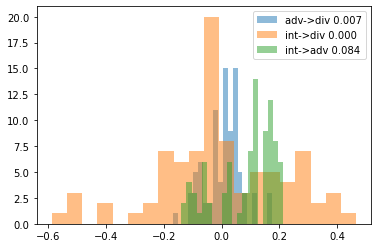

In [128]:
plt.hist(cor_adv_div ,bins=20,alpha=0.5,
         label='adv->div '+'{:.5}'.format(str(np.mean(cor_adv_div))))
plt.hist(cor_int_div ,bins=20,alpha=0.5,
         label='int->div '+'{:.5}'.format(str(np.mean(cor_int_div))))
plt.hist(cor_int_adv ,bins=20,alpha=0.5,
         label='int->adv '+'{:.5}'.format(str(np.mean(cor_int_adv))))
plt.legend()
plt.show()

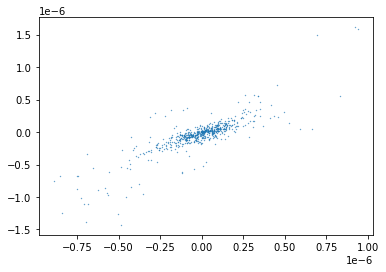

[[1.         0.83064516]
 [0.83064516 1.        ]]


In [194]:
# adv1 vs adv2
x = budadv[0]
y = budadv[1]
# x = buddiv[0]
# y = buddiv[1]
xymask = np.logical_and(np.isfinite(x),y<0.2)
plt.scatter(x[xymask],y[xymask],s=0.1)
plt.show()
print(np.corrcoef(x[xymask],y[xymask]))


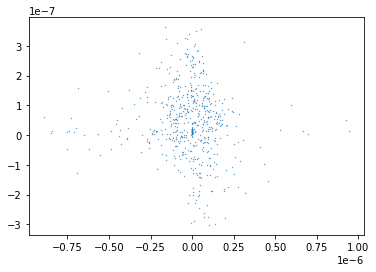

[[ 1.         -0.07506095]
 [-0.07506095  1.        ]]


In [195]:
# adv1 vs adv2
x = advtemp
y = divtemp
xymask = np.logical_and(np.isfinite(x),y<0.2)
plt.scatter(x[xymask],y[xymask],s=0.1)
plt.show()
print(np.corrcoef(x[xymask],y[xymask]))


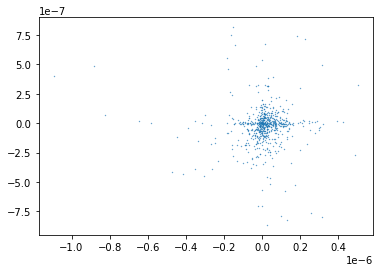

[[ 1.        -0.0216945]
 [-0.0216945  1.       ]]


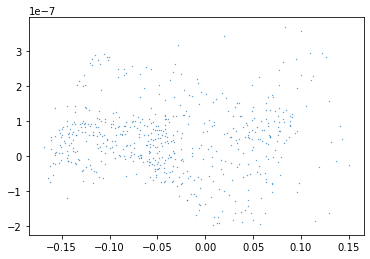

[[ 1.         -0.03365952]
 [-0.03365952  1.        ]]


In [132]:
# adv1 vs adv2
x = adv1
y = adv2
xymask = np.logical_and(np.isfinite(x),y<0.2)
plt.scatter(x[xymask],y[xymask],s=0.1)
plt.show()
print(np.corrcoef(x[xymask],y[xymask]))

# Vol vs gradU
x = Vslices[1,1:-1,1:-1]
y = divU
xymask = np.logical_and(np.isfinite(x),y<0.2)
plt.scatter(x[xymask],y[xymask],s=0.1)
plt.show()
print(np.corrcoef(x[xymask],y[xymask]))

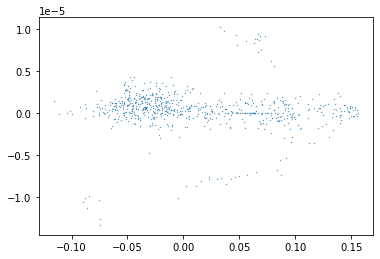

[[ 1.         -0.03241114]
 [-0.03241114  1.        ]]


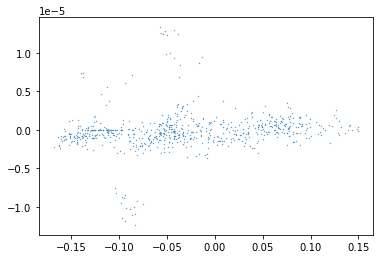

[[1.        0.1522529]
 [0.1522529 1.       ]]


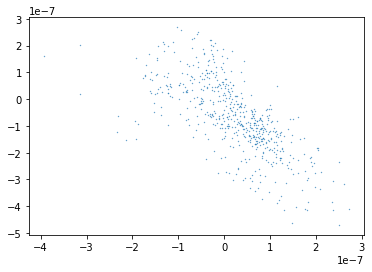

[[ 1.         -0.69405126]
 [-0.69405126  1.        ]]


In [134]:
# V1 vs divVol1
x = Uslices[1,1:-1,1:-1]
y = grdVol1
xymask = np.logical_and(np.isfinite(x),np.isfinite(y))
plt.scatter(x[xymask],y[xymask],s=0.1)
plt.show()
print(np.corrcoef(x[xymask],y[xymask]))

# V2 vs divVol2
x = Vslices[1,1:-1,1:-1]
y = grdVol2
xymask = np.logical_and(np.isfinite(x),np.isfinite(y))
plt.scatter(x[xymask],y[xymask],s=0.1)
plt.show()
print(np.corrcoef(x[xymask],y[xymask]))

# grdV1 vs grdV2
x = divV1[1:-1,1:-1]
y = divV2[1:-1,1:-1]
xymask = np.logical_and(np.isfinite(x),y<0.2)
plt.scatter(x[xymask],y[xymask],s=0.1)
plt.show()
print(np.corrcoef(x[xymask],y[xymask]))

-0.044899646410109934
-0.036639748694080244


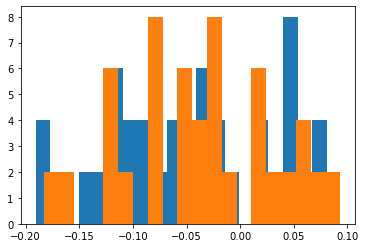

-0.5886935193725694


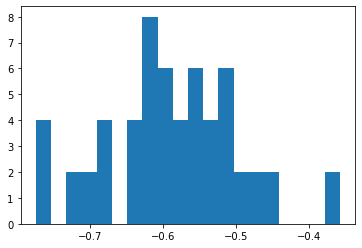

In [193]:
plt.hist(cor_sigu1grdVol1 ,bins=20)
plt.hist(cor_sigu2grdVol2,bins=20)
print(np.mean(cor_sigu1grdVol1))
print(np.mean(cor_sigu2grdVol2))
plt.show()
plt.hist(cor_sigdivu1divu2,bins=20)
print(np.mean(cor_sigdivu1divu2))
plt.show()

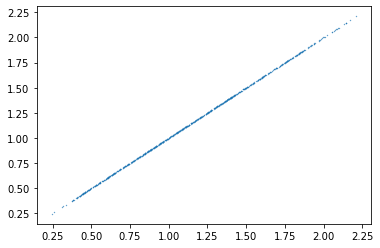

[[1. 1.]
 [1. 1.]]


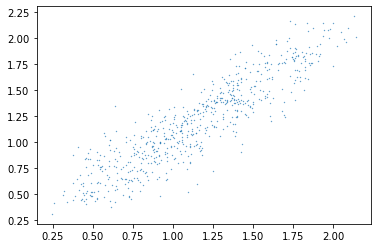

[[1.         0.90132677]
 [0.90132677 1.        ]]


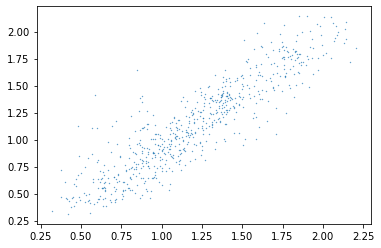

[[1.         0.89911864]
 [0.89911864 1.        ]]


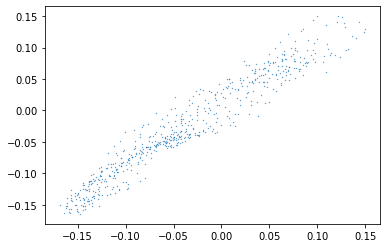

[[1.         0.96698313]
 [0.96698313 1.        ]]


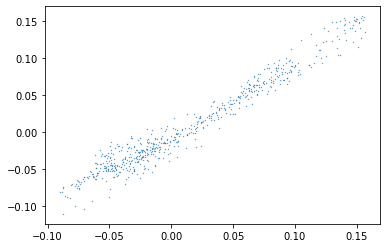

[[1.         0.97779496]
 [0.97779496 1.        ]]


In [135]:
tstep = 1
x = Tslices[2-tstep]
y = Tslices[2]
xymask = np.logical_and(x>0.2,y>0.2)
plt.scatter(x[xymask],y[xymask],s=0.1)
plt.show()
print(np.corrcoef(x[xymask],y[xymask]))

dstep = 2
x = Vol_slices[1,1:-1,dstep:]
y = Vol_slices[1,1:-1,:-dstep]
xymask = np.logical_and(x>0.2,y>0.2)
plt.scatter(x[xymask],y[xymask],s=0.1)
plt.show()
print(np.corrcoef(x[xymask],y[xymask]))

dstep = 2
x = Vol_slices[1,dstep:,1:-1]
y = Vol_slices[1,:-dstep,1:-1]
xymask = np.logical_and(x>0.2,y>0.2)
plt.scatter(x[xymask],y[xymask],s=0.1)
plt.show()
print(np.corrcoef(x[xymask],y[xymask]))

dstep = 2
x = Vslices[1,1:-1,dstep:]
y = Vslices[1,1:-1,:-dstep]
xymask = np.logical_and(x<0.2,y<0.2)
plt.scatter(x[xymask],y[xymask],s=0.1)
plt.show()
print(np.corrcoef(x[xymask],y[xymask]))

dstep = 2
x = Uslices[1,dstep:,1:-1]
y = Uslices[1,:-dstep,1:-1]
xymask = np.logical_and(x<0.2,y<0.2)
plt.scatter(x[xymask],y[xymask],s=0.1)
plt.show()
print(np.corrcoef(x[xymask],y[xymask]))

0.9993148338446806


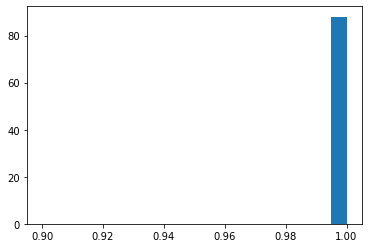

0.9179760319966921
0.9196269658043744


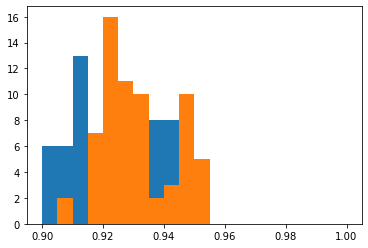

0.9338478343833024
0.931889951200834


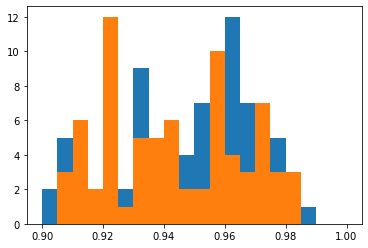

In [136]:
plt.hist(cor_dVdt,bins=20,range=[0.9,1.0])
print(np.mean(cor_dVdt))
plt.show()
plt.hist(cor_grdV1,bins=20,range=[0.9,1.0])
plt.hist(cor_grdV2,bins=20,range=[0.9,1.0])
print(np.mean(cor_grdV1))
print(np.mean(cor_grdV2))
plt.show()
plt.hist(cor_divU1,bins=20,range=[0.9,1.0])
plt.hist(cor_divU2,bins=20,range=[0.9,1.0])
print(np.mean(cor_divU1))
print(np.mean(cor_divU2))
plt.show()

In [185]:
# [0.90**(dc+1) for dc in range(12)]

In [48]:
#### quick polygon to only include the plotted area
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

x_vect = [lims[0],lims[0],lims[1],lims[1]]
y_vect = [lims[2],lims[3],lims[3],lims[2]]
poly_vect = np.column_stack((y_vect,x_vect)) # Reshape coordinates
polygon = Polygon(poly_vect) # create polygon

In [49]:
#### quick polygon to only include the plotted area
testm = np.ones(GV.shape,dtype=bool)
for i in range(GV.m):
    for j in range(GV.n):
        point = Point(GV.ypts[i,j],GV.xpts[i,j])
        testm[i,j] = polygon.contains(point)

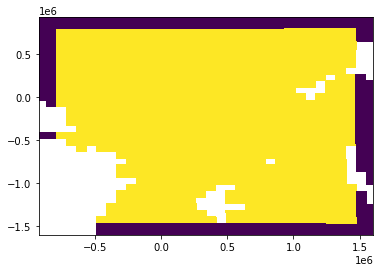

In [50]:
plt.pcolormesh(GV.xpts,GV.ypts,testm*GV.mask)
plt.xlim([lims[0]*1.1,lims[1]*1.1,])
plt.ylim([lims[2]*1.1,lims[3]*1.1,])
plt.show()

In [420]:
fig_dir = 'Steps_figs/'

In [60]:

hist['V'].mean()
hist['V_sig'].count.max()

/Users/h/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


30

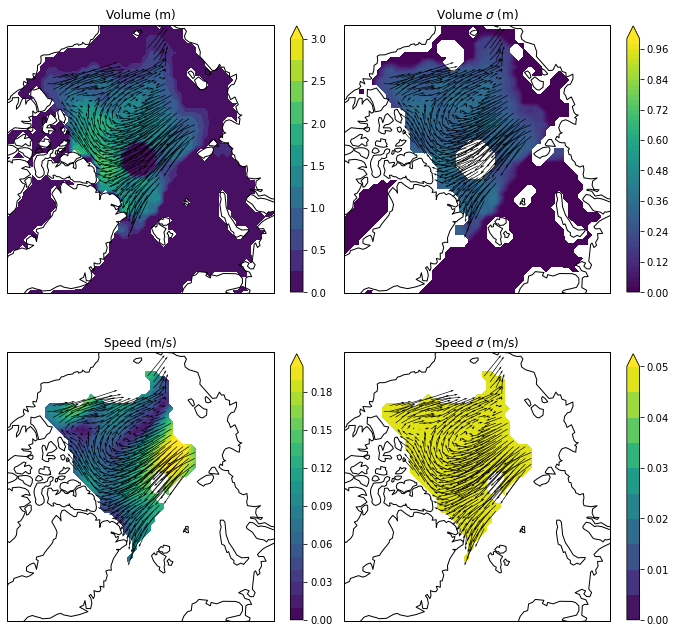

In [182]:
vsc = 1.3
points = [[-30,75],[120,75],[0,90]] ## central barents
# points = [[0,75],[60,75],[0,86]] ### zoom barents edge #### force map to include these points
# points = [[-175,72],[-140,68],[-160,86]] ## Beaufort ish
lims = GV.lims_from_lonlat(points,for_extent = True)
level_list = [
    np.arange(0,3.25,0.25),
    np.arange(0,1.02,0.02),
    np.arange(0,0.21,0.01),
    np.arange(0,0.055,0.005),
#     np.arange(0,3.25,0.25),
#     np.arange(0,1.45,0.05),
#     np.arange(0,0.16,0.01),
# #     np.arange(0,0.055,0.005),
#     np.arange(0,0.11,0.01),
]
arr_list = [
    Vol_slices[1],
    Volerrslices[1],
    np.hypot(Uslices[1],Vslices[1]),
    np.hypot(Uerrslices[1],Verrslices[1]),
#     Verrslices[1],
#     hist['Vol'].mean(),
#     np.sqrt(hist['Vol_sig'].mean()),
#     np.hypot(hist['U'].mean(),hist['V'].mean()),
#     np.sqrt(np.hypot(hist['U_sig'].mean(),hist['V_sig'].mean()))
]
cmap_list = [
    plt.cm.viridis
]*4
lab_list = ['Volume (m)','Volume $\sigma$ (m)',
           'Speed (m/s)','Speed $\sigma$ (m/s)'
           ]
xv,yv = G2Gplocal.rg_vecs(Uslices[1],Vslices[1])
# xv,yv = G2Gplocal.rg_vecs(hist['U'].mean(),hist['V'].mean())
#### plot concentration (vel grid)
f = plt.figure(figsize=( 12,12))
for ns,(arr,levels,cmap,lab) in enumerate(zip(arr_list,level_list,cmap_list,lab_list)):
    ax = f.add_subplot(2,2,ns+1,projection=m)
#     ax.set_extent(lims,m)
    ax.set_extent([-180, 180, 70, 90], ccrs.PlateCarree())
    # s = ax.contourf(Gthk.xpts,Gthk.ypts,Tslices[0],levels = levels)
    s = ax.contourf(GV.xpts,GV.ypts,arr,levels = levels,
                    cmap = cmap,extend='max')
    ax.quiver(Gplocal.xpts,Gplocal.ypts,xv,yv,scale = vsc)
    ax.add_feature(cfeature.COASTLINE)
    plt.colorbar(s,shrink=0.82)
    ax.set_title(lab)
    

plt.subplots_adjust(wspace=0.01,hspace=0.01)
plt.show()
# f.savefig(fig_dir+'Inputs_single_day.png',bbox_inches='tight')

/Users/h/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


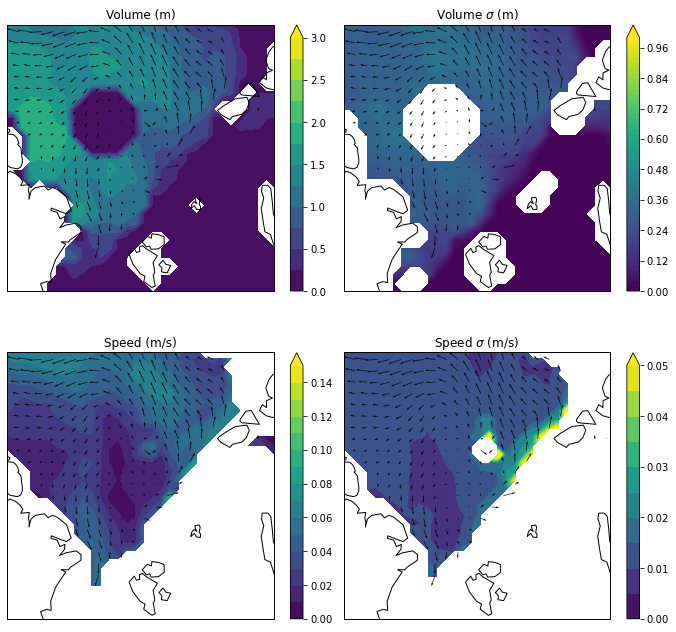

In [183]:
points = [[-30,75],[120,75],[0,90]] ## central barents
# points = [[0,75],[60,75],[0,86]] ### zoom barents edge #### force map to include these points
# points = [[-175,72],[-140,68],[-160,86]] ## Beaufort ish
lims = GV.lims_from_lonlat(points,for_extent = True)
level_list = [
#     np.arange(0,3.25,0.25),
#     np.arange(0,1.02,0.02),
#     np.arange(0,0.21,0.01),
#     np.arange(0,0.11,0.01),
    np.arange(0,3.25,0.25),
    np.arange(0,1.02,0.02),
#     np.arange(0,1.45,0.05),
    np.arange(0,0.16,0.01),
#     np.arange(0,0.055,0.005),
    np.arange(0,0.055,0.005),
]
arr_list = [
#     Vol_slices[1],
#     Volerrslices[1],
#     np.hypot(Uslices[1],Vslices[1]),
#     np.hypot(Uerrslices[1],Verrslices[1]),
    hist['Vol'].mean(),
    np.sqrt(hist['Vol_sig'].mean()/hist['Vol_sig'].count),
    np.hypot(hist['U'].mean(),hist['V'].mean()),
    np.sqrt(np.hypot(hist['U_sig'].mean(),hist['V_sig'].mean())/hist['V_sig'].count)
]
cmap_list = [
    plt.cm.viridis
]*4
lab_list = ['Volume (m)','Volume $\sigma$ (m)',
           'Speed (m/s)','Speed $\sigma$ (m/s)'
           ]
# xv,yv = G2Gplocal.rg_vecs(Uslices[1],Vslices[1])
xv,yv = G2Gplocal.rg_vecs(hist['U'].mean(),hist['V'].mean())
#### plot concentration (vel grid)
f = plt.figure(figsize=( 12,12))
for ns,(arr,levels,cmap,lab) in enumerate(zip(arr_list,level_list,cmap_list,lab_list)):
    ax = f.add_subplot(2,2,ns+1,projection=m)
    ax.set_extent(lims,m)
#     ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
    # s = ax.contourf(Gthk.xpts,Gthk.ypts,Tslices[0],levels = levels)
    s = ax.contourf(GV.xpts,GV.ypts,arr,levels = levels,
                    cmap = cmap,extend='max')
    ax.quiver(Gplocal.xpts,Gplocal.ypts,xv,yv,scale = vsc)
    ax.add_feature(cfeature.COASTLINE)
    plt.colorbar(s,shrink=0.82)
    ax.set_title(lab)
    

plt.subplots_adjust(wspace=0.01,hspace=0.01)
plt.show()
# f.savefig(fig_dir+'Inputs_single_day.png',bbox_inches='tight')

/Users/h/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


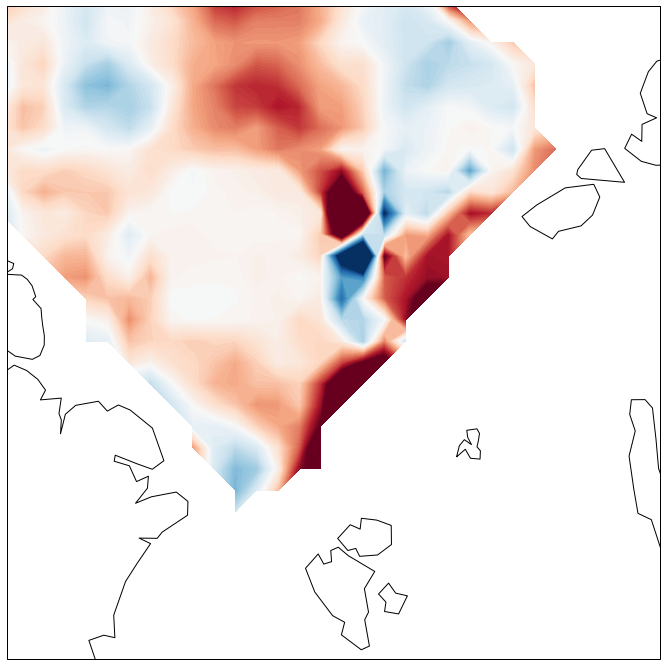

In [139]:
bud_scale = nsecs
test_div = b.divergence(hist['U'].mean(),hist['V'].mean(),hist['Vol'].mean(),Gvel)
# divtemp = hist['U'].mean()[2:,1:-1]-hist['U'].mean()[:-2,1:-1]
# divtemp += hist['V'].mean()[1:-1,2:]-hist['V'].mean()[1:-1,2:]
# test_div = np.pad(divtemp,((1,1),(1,1)),'constant',constant_values = np.nan)
f = plt.figure(figsize=( 12,12))
ax = f.add_subplot(1,1,1,projection=m)
ax.set_extent(lims,m)
#     ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
# s = ax.contourf(Gthk.xpts,Gthk.ypts,Tslices[0],levels = levels)
# lmax = 500.0
lmax = 0.02
levels = np.arange(-lmax,lmax*1.02,lmax*0.02)
s = ax.contourf(GV.xpts,GV.ypts,test_div*bud_scale,levels = levels,
                cmap = plt.cm.RdBu,extend='both')
ax.add_feature(cfeature.COASTLINE)
plt.show()

/Users/h/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


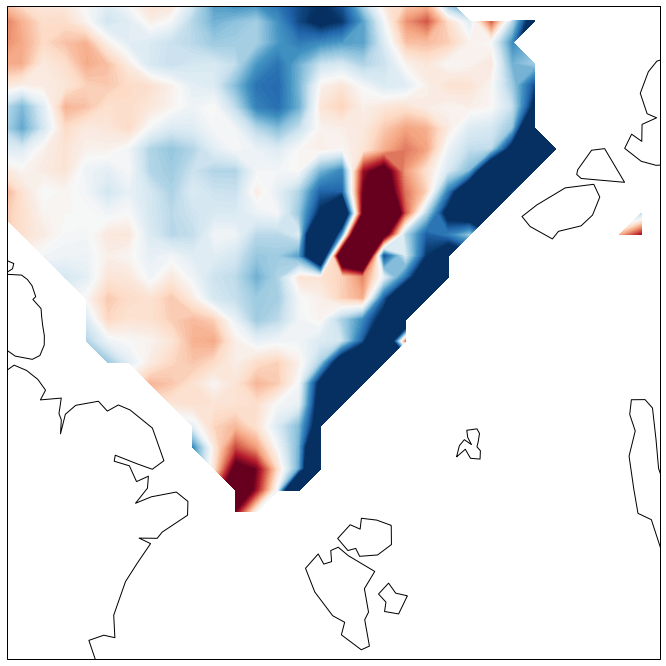

In [140]:
# test_div = b.divergence(hist['U'].mean(),hist['V'].mean(),hist['Vol'].mean(),Gvel)
# divtemp  = (hist['U'].mean()[2:,1:-1]-hist['U'].mean()[:-2,1:-1])/(2*Gvel.xdist[1:-1,1:-1])
divtemp  = (hist['V'].mean()[1:-1,2:]-hist['V'].mean()[1:-1,:-2])/(2*Gvel.xdist[1:-1,1:-1])
test_div = np.pad(divtemp,((1,1),(1,1)),'constant',constant_values = np.nan)#*hist['Vol'].mean()
f = plt.figure(figsize=( 12,12))
ax = f.add_subplot(1,1,1,projection=m)
ax.set_extent(lims,m)
#     ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
# s = ax.contourf(Gthk.xpts,Gthk.ypts,Tslices[0],levels = levels)
# lmax = 500.0
lmax = 0.01
levels = np.arange(-lmax,lmax*1.02,lmax*0.02)
s = ax.contourf(GV.xpts,GV.ypts,test_div*bud_scale,levels = levels,
                cmap = plt.cm.RdBu,extend='both')
ax.add_feature(cfeature.COASTLINE)
plt.show()

/Users/h/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


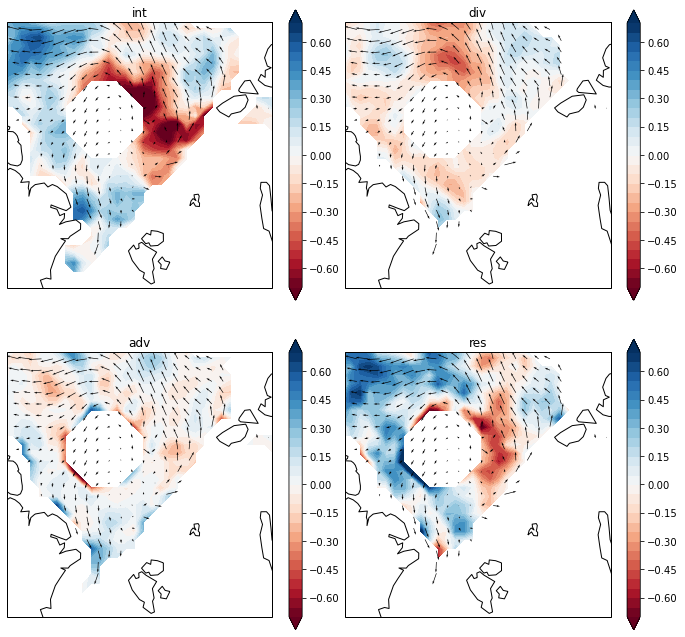

In [141]:
# levels = np.arange(0,1.0,0.25)
# levels = [0.0,0.15,0.5,0.8,0.9,0.95,0.97,0.98,0.985,0.99,0.995,1.0]
# levels = np.arange(-1.3,1.35,0.05)
lmax = 0.7
levels = np.arange(-lmax,lmax+0.05,0.05)
# lmax = 0.1
# levels = np.arange(-lmax,lmax+0.01,0.01)
bud_scale = nsecs
vsc = 1.3
#### plot concentration (vel grid)
f = plt.figure(figsize=( 12,12))
for ns,var in enumerate(['int','div','adv','res']):
    xv,yv = G2Gplocal.rg_vecs(hist['U'].mean(),hist['V'].mean())
    ax = f.add_subplot(2,2,ns+1,projection=m)
    ax.set_extent(lims,m)
#     ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
    # s = ax.contourf(Gthk.xpts,Gthk.ypts,Tslices[0],levels = levels)
    s = ax.contourf(GV.xpts,GV.ypts,hist[var].total()*bud_scale,levels = levels,
                    cmap = plt.cm.RdBu,extend='both')
#     s = ax.pcolormesh(GV.xptp,GV.yptp,hist[var].total()*bud_scale,cmap = plt.cm.RdBu)
    ax.quiver(Gplocal.xpts,Gplocal.ypts,xv,yv,scale = vsc)
    ax.add_feature(cfeature.COASTLINE)
    plt.colorbar(s,shrink=0.9)
    ax.set_title(var)
    

plt.subplots_adjust(wspace=0.02,hspace=0.02)
plt.show()
# f.savefig(fig_dir+'Outputs_single_day.png',bbox_inches='tight')
# f.savefig(fig_dir+'Outputs_monthly.png',bbox_inches='tight')

/Users/h/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


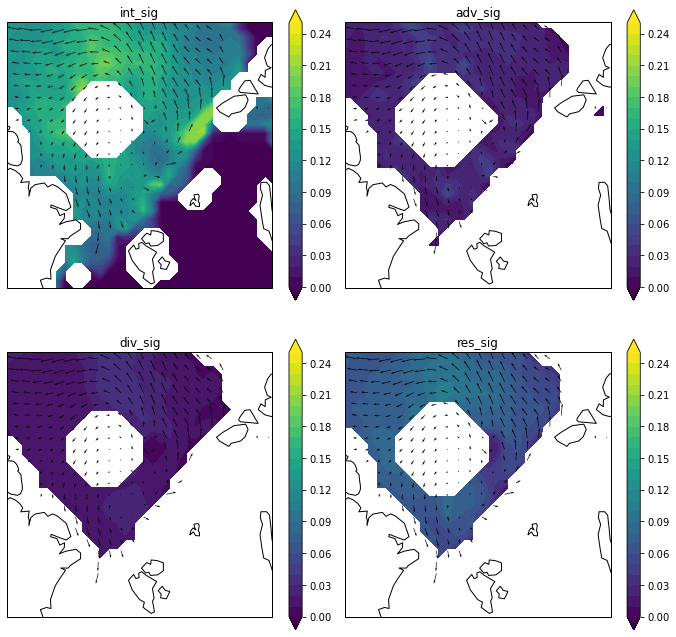

In [57]:
# levels = np.arange(0,1.05,0.05)
# levels = [0.0,0.15,0.5,0.8,0.9,0.95,0.97,0.98,0.985,0.99,0.995,1.0]
# levels = np.arange(-1.3,1.35,0.05)
lmax = 0.25
levels = np.arange(0.0,lmax+0.01,0.01)
# lmax = 0.05
# levels = np.arange(0.0,lmax+0.001,0.001)
# levels *= 0.3
# levels *= 0.3
bud_scale = nsecs
vsc = 1.3
#### plot concentration (vel grid)
f = plt.figure(figsize=( 12,12))
for ns,var in enumerate(['int_sig','adv_sig','div_sig','res_sig']):
    xv,yv = G2Gplocal.rg_vecs(hist['U'].mean(),hist['V'].mean())
    ax = f.add_subplot(2,2,ns+1,projection=m)
    ax.set_extent(lims,m)
#     ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
    # s = ax.contourf(Gthk.xpts,Gthk.ypts,Tslices[0],levels = levels)
    s = ax.contourf(GV.xpts,GV.ypts,np.sqrt(hist[var].total())*bud_scale,levels = levels,
#     s = ax.contourf(GV.xpts,GV.ypts,hist[var].total()*bud_scale**2,levels = levels,
                    cmap = plt.cm.viridis,extend='both')
#     s = ax.pcolormesh(GV.xptp,GV.yptp,hist[var].total()*bud_scale,cmap = plt.cm.RdBu)
    ax.quiver(Gplocal.xpts,Gplocal.ypts,xv,yv,scale = vsc)
    ax.add_feature(cfeature.COASTLINE)
    plt.colorbar(s,shrink=0.9)
    ax.set_title(var)
    

plt.subplots_adjust(wspace=0.02,hspace=0.02)
plt.show()
# f.savefig(fig_dir+'Outputs_err_monthly.png',bbox_inches='tight')

/Users/h/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/Users/h/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide


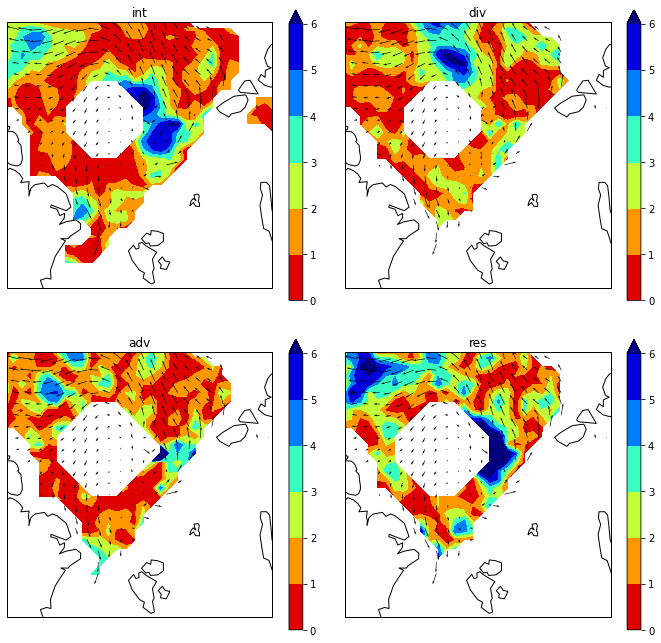

In [142]:
# levels = np.arange(0,1.0,0.25)
# levels = [0.0,0.15,0.5,0.8,0.9,0.95,0.97,0.98,0.985,0.99,0.995,1.0]
# levels = np.arange(-1.3,1.35,0.05)
lmax = 7.0
levels = np.arange(0.0,lmax,1.0)
# lmax = 0.1
# levels = np.arange(-lmax,lmax+0.01,0.01)
bud_scale = nsecs
vsc = 1.3
#### plot concentration (vel grid)
f = plt.figure(figsize=( 12,12))
for ns,var in enumerate(['int','div','adv','res']):
    xv,yv = G2Gplocal.rg_vecs(hist['U'].mean(),hist['V'].mean())
    ax = f.add_subplot(2,2,ns+1,projection=m)
    ax.set_extent(lims,m)
#     ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
    # s = ax.contourf(Gthk.xpts,Gthk.ypts,Tslices[0],levels = levels)
    ### signal to noise
    s_to_n = np.abs(hist[var].total())/np.sqrt(hist[var+'_sig'].total())
    s = ax.contourf(GV.xpts,GV.ypts,s_to_n,levels = levels,
                    cmap = plt.cm.jet_r,extend='max')
#     s = ax.pcolormesh(GV.xptp,GV.yptp,hist[var].total()*bud_scale,cmap = plt.cm.RdBu)
    ax.quiver(Gplocal.xpts,Gplocal.ypts,xv,yv,scale = vsc)
    ax.add_feature(cfeature.COASTLINE)
    plt.colorbar(s,shrink=0.9)
    ax.set_title(var)
    

plt.subplots_adjust(wspace=0.02,hspace=0.02)
plt.show()
# f.savefig(fig_dir+'Outputs_single_day.png',bbox_inches='tight')
# f.savefig(fig_dir+'Outputs_monthly.png',bbox_inches='tight')

/Users/h/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/Users/h/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide


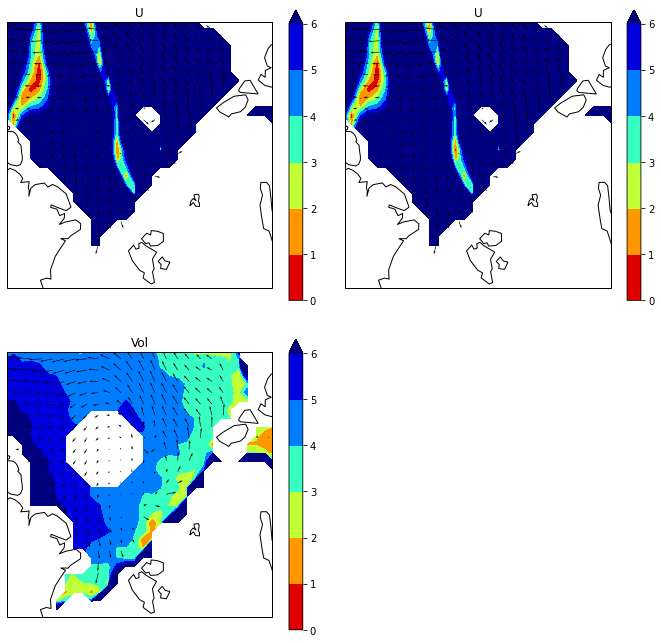

In [59]:
# levels = np.arange(0,1.0,0.25)
# levels = [0.0,0.15,0.5,0.8,0.9,0.95,0.97,0.98,0.985,0.99,0.995,1.0]
# levels = np.arange(-1.3,1.35,0.05)
lmax = 7.0
levels = np.arange(0.0,lmax,1.0)
# lmax = 0.1
# levels = np.arange(-lmax,lmax+0.01,0.01)
bud_scale = nsecs
vsc = 1.3
#### plot concentration (vel grid)
f = plt.figure(figsize=( 12,12))
for ns,var in enumerate(['U','U','Vol']):
    xv,yv = G2Gplocal.rg_vecs(hist['U'].mean(),hist['V'].mean())
    ax = f.add_subplot(2,2,ns+1,projection=m)
    ax.set_extent(lims,m)
#     ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
    # s = ax.contourf(Gthk.xpts,Gthk.ypts,Tslices[0],levels = levels)
    ### signal to noise
    s_to_n = np.abs(hist[var].total())/np.sqrt(hist[var+'_sig'].total())
    s = ax.contourf(GV.xpts,GV.ypts,s_to_n,levels = levels,
                    cmap = plt.cm.jet_r,extend='max')
#     s = ax.pcolormesh(GV.xptp,GV.yptp,hist[var].total()*bud_scale,cmap = plt.cm.RdBu)
    ax.quiver(Gplocal.xpts,Gplocal.ypts,xv,yv,scale = vsc)
    ax.add_feature(cfeature.COASTLINE)
    plt.colorbar(s,shrink=0.9)
    ax.set_title(var)
    

plt.subplots_adjust(wspace=0.02,hspace=0.02)
plt.show()
# f.savefig(fig_dir+'Outputs_single_day.png',bbox_inches='tight')
# f.savefig(fig_dir+'Outputs_monthly.png',bbox_inches='tight')

In [186]:
### don't think this works...
def sum_array_sig(array,sig2):
#     𝜎2=∑𝑁(𝑥𝑗−𝜇)/2𝑁−1
#     =∑𝑑∑𝑁𝑑(𝑥𝑗−𝜇)2𝑁−1
#     =∑𝑑(𝜎2𝑑(𝑁𝑑−1)+𝑁𝑑(𝜇−𝜇𝑑)2)/𝑁−1
#     equiv to: (sum(sig2)/N-1 + std(array)**2)N
    n_points = np.isfinite(array).sum()
    var_mean2 = np.nansum(sig2)/(n_points-1) + np.nanstd(array)**2
    return np.nansum(array),np.sqrt(var_mean2*n_points)

In [187]:
budscale = nsecs*1e-9
for var in ['int','adv','div','res','dyn']:
    print(var)
    array = hist[var].total()*Gvel.area*budscale*testm*GV.mask
    sig2 = hist[var+'_sig'].total()*Gvel.area**2*budscale**2
#     print(np.nanstd(array)**2)
    print(np.nansum(array))
#     print(np.nansum(hist[var].total()*Gvel.area)*budscale)
#     print(np.nansum(hist[var].total()*Gvel.area)*1e-9)
    print(np.sqrt(np.nansum(hist[var+'_sig'].total()*(Gvel.area**2)))*budscale)
    print(np.nansum(np.sqrt(hist[var+'_sig'].total())*Gvel.area)*budscale)
    s_to_n = np.abs(array)/np.sqrt(sig2)
    print(np.nanmean(s_to_n))
    print(np.sum(s_to_n>2)/np.sum(s_to_n>0))

int
-42.76007050441502
22.57325668926361
683.6792496818497
0.8480543515805635
0.3087248322147651
adv
-3.062695168477134
8.165514127770159
191.8759173110778
0.8107365522943847
0.27696793002915454
div
-126.43545239438151
10.204901951082705
238.8563805936239
0.890425829876066
0.35195530726256985
res
165.2027185234741
13.575209239679303
323.1020572049612
1.242095535898673
0.5107033639143731
dyn
-136.0180561549657
12.174024761382139
277.1012282487357
0.8827962879678737
0.28888888888888886


/Users/h/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


In [188]:
budscale = nsecs*1e-12
for var in ['int','adv','div','res','dyn']:
    print(var)
    vsum,vsig = sum_array_sig(hist[var].total()*Gvel.area*budscale,
                             hist[var+'_sig'].total()*Gvel.area**2*budscale**2)
    print(vsum)
    print(vsig)
    array = hist[var].total()*Gvel.area*budscale
    sig2 = hist[var+'_sig'].total()*Gvel.area**2*budscale**2
#     print(np.nanstd(array)**2)
#     print(np.nansum(hist[var].total()*Gvel.area)*budscale)
#     print(np.nansum(hist[var].total()*Gvel.area)*1e-9)
    print(np.sqrt(np.nansum(hist[var+'_sig'].total()*(Gvel.area**2)))*budscale)
    print(np.nansum(np.sqrt(hist[var+'_sig'].total())*Gvel.area)*budscale)

int
0.1214677389201715
0.04976334525801841
0.022573256689263608
0.6836792496818496
adv
0.11144628741913087
0.02415642708694959
0.008165514127770158
0.1918759173110778
div
-0.12811389440893256
0.023132927705799528
0.010204901951082706
0.23885638059362388
res
0.24506987263195604
0.03775956712024851
0.013575209239679302
0.3231020572049612
dyn
-0.048769855929884726
0.031442479684294054
0.012174024761382138
0.27710122824873573


In [313]:
for var in ['int','adv','div','res','dyn']:
    print(var)
    print(np.nansum(hist[var].total()*Gvel.area)*10e-9)
#     print(np.nansum(hist[var].total()*Gvel.area)*10e-9)
    print(np.sqrt(np.nansum(hist[var+'_sig'].total()*(Gvel.area**2)))*10e-9)
    print(np.nansum(np.sqrt(hist[var+'_sig'].total())*Gvel.area)*10e-9)

int
0.2673335030662116
0.0007585067711187909
0.07021081579881641
adv
-0.007197331253649262
0.0006349914213922935
0.05256850823592606
div
-0.0033969345637340116
0.0006590462447610494
0.05945050447541465
res
0.2681671099749307
0.0010641606241459346
0.09039624741365228
dyn
-0.01132956997523739
0.000872646458898394
0.07336236086239369


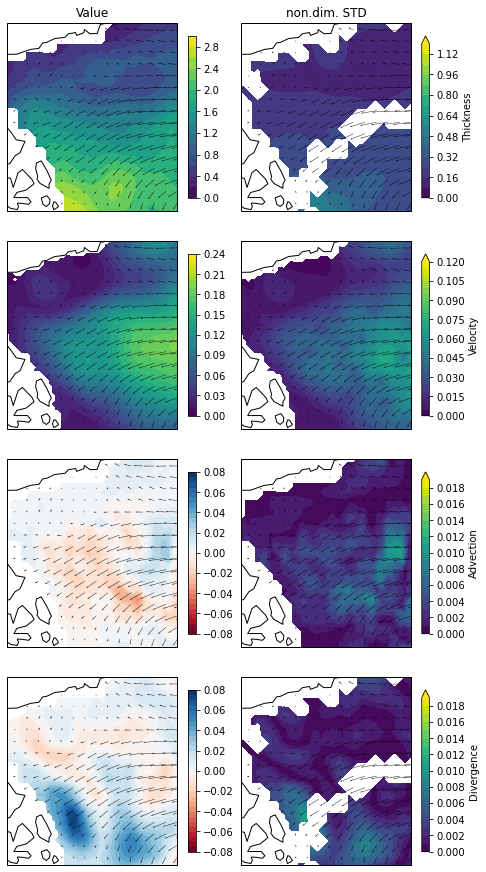

In [1014]:
#### thickness, thickness err, 
### Vel speed, vel speed err
### advection, advection err, 
### div, div err
tlevels = np.arange(0,3.2,0.2)
vlevels = np.arange(0,0.25,0.01)
levels = np.arange(-0.08,0.085,0.005)
slevels = np.arange(0.,1.0,0.05)
PLIST = [
#     [Ttemp,Terrt,tlevels,tlevels*0.4,plt.cm.viridis,plt.cm.viridis],
#     [np.hypot(Utemp,Vtemp),np.hypot(Utemp,Vtemp)*Verrt,vlevels,vlevels*0.4,plt.cm.viridis,plt.cm.viridis],
#     [un.nominal_values(uadv)*nsecs,un.std_devs(uadv)*nsecs,levels,slevels*2,plt.cm.RdBu,plt.cm.viridis],
#     [un.nominal_values(udiv)*nsecs,un.std_devs(udiv)*nsecs,levels,slevels*3,plt.cm.RdBu,plt.cm.viridis],
    {'v1':Ttemp,'v2':Terrt,'l1':tlevels,'l2':tlevels*0.4,'c1':plt.cm.viridis,'c2':plt.cm.viridis,'lb':'Thickness'},
    {'v1':np.hypot(Utemp,Vtemp),'v2':np.hypot(Utemp,Vtemp)*Verrt,'l1':vlevels,'l2':vlevels*0.5,'c1':plt.cm.viridis,'c2':plt.cm.viridis,'lb':'Velocity'},
    {'v1':un.nominal_values(uadv)*nsecs,'v2':un.std_devs(uadv)*nsecs,
     'l1':levels,'l2':slevels*0.02,'c1':plt.cm.RdBu,'c2':plt.cm.viridis,'lb':'Advection'},
    {'v1':un.nominal_values(udiv)*nsecs,'v2':un.std_devs(udiv)*nsecs,
     'l1':levels,'l2':slevels*0.02,'c1':plt.cm.RdBu,'c2':plt.cm.viridis,'lb':'Divergence'},
    
#     {'v1':Ttemp,'v2':Terrt/Ttemp,'l1':tlevels,'l2':slevels*0.4,'c1':plt.cm.viridis,'c2':plt.cm.viridis,'lb':'Thickness'},
#     {'v1':np.hypot(Utemp,Vtemp),'v2':Verrt,'l1':vlevels,'l1':slevels*0.5,'c1':plt.cm.viridis,'c2':plt.cm.viridis,'lb':'Velocity'},
#     {'v1':un.nominal_values(uadv)*nsecs,'v2':np.abs(un.std_devs(uadv)/un.nominal_values(uadv)),
#      'l1':levels,'l2':slevels,'c1':plt.cm.RdBu,'c2':plt.cm.viridis,'lb':'Advection'},
#     {'v1':un.nominal_values(udiv)*nsecs,'v2':np.abs(un.std_devs(udiv)/un.nominal_values(udiv)),
#      'l1':levels,'l2':slevels*40,'c1':plt.cm.RdBu,'c2':plt.cm.viridis,'lb':'Divergence'},
]
# vsc = 0.8
vsc = 1.8
# points = [[0,75],[60,75],[0,86]]
points = [[-175,72],[-140,68],[-160,86]] ## Beaufort ish
lims = GV.lims_from_lonlat(points,for_extent = True)
zoom = True
scale_err = False
#### plot Velocity (velocity grid)
xv,yv = G2Gplocal.rg_vecs(Utemp,Vtemp)

f = plt.figure(figsize=(8, 16))
for ns,PL in enumerate(PLIST[0:]):
    ax = f.add_subplot(4,2,2*ns+1,projection=m)
    if zoom: ax.set_extent(lims,m)
    else: ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
    if ns == 0: ax.set_title('Value')
    ### VAR
    s = ax.contourf(GV.xpts,GV.ypts,PL['v1'],levels = PL['l1'],cmap = PL['c1'])#,extend='max')
    ax.quiver(Gplocal.xpts,Gplocal.ypts,xv,yv,scale = vsc)
    ax.add_feature(cfeature.COASTLINE)
    ax.yaxis.set_label(PL['lb'])
#     plt.colorbar(s,  pad=-0.18,shrink= 0.75);
    cax = plt.colorbar(s,  shrink= 0.75);
#     break
     
    ax = f.add_subplot(4,2,2*ns+2,projection=m)
    if zoom: ax.set_extent(lims,m)
    else: ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
    ### ERR
    if ns == 0: ax.set_title('non.dim. STD')
    levels = PL['l2']
    if scale_err: levels = slevels*np.round(np.nanpercentile(PL['v2'],[95])[0],1)
    s = ax.contourf(GV.xpts,GV.ypts,PL['v2'],levels = levels,cmap = PL['c2'],extend='max')
    ax.quiver(Gplocal.xpts,Gplocal.ypts,xv,yv,scale = vsc)
    ax.add_feature(cfeature.COASTLINE)
#     plt.colorbar(s,  pad=-0.18,shrink= 0.75);
    cax = plt.colorbar(s,  shrink= 0.75);
    cax.set_label(PL['lb'])
        

plt.subplots_adjust(hspace=0.01,wspace = 0.1)
f.savefig('Error_test_plots/'+d.strftime('%Y%m%d')+'_Beaufort_no_gradient_err_total_smooth.png',bbox_inches='tight')
plt.show()

In [ ]:
#### thickness, thickness err, 
### Vel speed, vel speed err
### advection, advection err, 
### div, div err
zoom = False
tlevels = np.arange(0,3.2,0.2)
vlevels = np.arange(0,0.25,0.01)
levels = np.arange(-0.03,0.035,0.005)
slevels = np.arange(0.,0.1,0.01)
PLIST = [
    [Ttemp,Terrt,tlevels,tlevels*0.4,plt.cm.viridis,plt.cm.viridis],
    [np.hypot(Utemp,Vtemp),np.hypot(Utemp,Vtemp)*Verrt,vlevels,vlevels*0.4,plt.cm.viridis,plt.cm.viridis],
    [un.nominal_values(uadv)*nsecs,un.std_devs(uadv)*nsecs,levels,slevels*0.2,plt.cm.RdBu,plt.cm.viridis],
    [un.nominal_values(udiv)*nsecs,un.std_devs(udiv)*nsecs,levels,slevels*0.3,plt.cm.RdBu,plt.cm.viridis],
#     [Ttemp,Terrt/Ttemp,tlevels,slevels*5,plt.cm.viridis],
#     [np.hypot(Utemp,Vtemp),Verrt,vlevels,slevels*6,plt.cm.viridis],
#     [un.nominal_values(uadv)*nsecs,un.std_devs(uadv)/un.nominal_values(uadv),levels,slevels,plt.cm.RdBu],
#     [un.nominal_values(udiv)*nsecs,un.std_devs(udiv)/un.nominal_values(udiv),levels,slevels*40,plt.cm.RdBu],
]
# vsc = 0.8
vsc = 1.8
points = [[0,75],[60,75],[0,86]]
lims = GV.lims_from_lonlat(points,for_extent = True)
#### plot Velocity (velocity grid)
xv,yv = G2Gplocal.rg_vecs(Utemp,Vtemp)

f = plt.figure(figsize=(8, 28))
for ns,PL in enumerate(PLIST[0:]):
    ax = f.add_subplot(8,2,2*ns+1,projection=m)
    if zoom: ax.set_extent(lims,m)
    else: ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
    ### VAR
    s = ax.contourf(GV.xpts,GV.ypts,PL[0],levels = PL[2],cmap = PL[4])#,extend='max')
    ax.quiver(Gplocal.xpts,Gplocal.ypts,xv,yv,scale = vsc)
    ax.add_feature(cfeature.COASTLINE)
    plt.colorbar(s,  pad=-0.18,shrink= 0.75);
#     break
     
    ax = f.add_subplot(8,2,2*ns+2,projection=m)
    if zoom: ax.set_extent(lims,m)
    else: ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
#     ax.set_extent(lims,m)
    ### ERR
    s = ax.contourf(GV.xpts,GV.ypts,PL[1],levels = PL[3],cmap = PL[5])#,extend='max')
    ax.quiver(Gplocal.xpts,Gplocal.ypts,xv,yv,scale = vsc)
    ax.add_feature(cfeature.COASTLINE)
    plt.colorbar(s,  pad=-0.18,shrink= 0.75);
        

plt.subplots_adjust(hspace=0.01,wspace = 0.1)
plt.show()

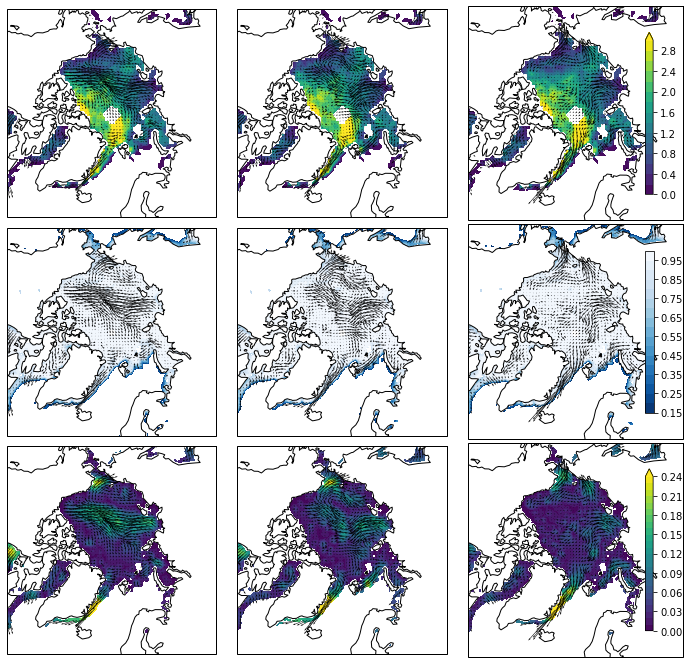

In [392]:
tlevels = np.arange(0,3.2,0.2)
clevels = np.arange(0.15,1.05,0.05)
vlevels = np.arange(0,0.25,0.01)
vsc = 2.5
points = [[0,75],[60,75],[0,86]]
lims = GV.lims_from_lonlat(points,for_extent = True)
#### plot Velocity (velocity grid)
f = plt.figure(figsize=(12, 12))
for ns in range(3):
    xv,yv = G2Gplocal.rg_vecs(Uslices[ns],Vslices[ns])
    ax = f.add_subplot(3,3,ns+1,projection=m)
    ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
#     ax.set_extent(lims,m)
    ### THICKNESS
    s = ax.contourf(GV.xpts,GV.ypts,Tslices[ns],levels = tlevels,extend='max')
    ax.quiver(Gplocal.xpts,Gplocal.ypts,xv,yv,scale = vsc)
    ax.add_feature(cfeature.COASTLINE)
    if ns ==2: plt.colorbar(s,  pad=-0.18,shrink= 0.75);
#     break
     
    ax = f.add_subplot(3,3,ns+4,projection=m)
    ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
#     ax.set_extent(lims,m)
    ### CONC
    s = ax.contourf(GV.xpts,GV.ypts,Cslices[ns],levels = clevels,cmap = 'Blues_r')# custom_cmap)
    ax.quiver(Gplocal.xpts,Gplocal.ypts,xv,yv,scale = vsc)
    ax.add_feature(cfeature.COASTLINE)
    if ns ==2: plt.colorbar(s,  pad=-0.18,shrink= 0.75);
        
    ax = f.add_subplot(3,3,ns+7,projection=m)
    ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
#     ax.set_extent(lims,m)
    ### DRIFT
    s = ax.contourf(GV.xpts,GV.ypts,np.hypot(Uslices[ns],Vslices[ns]),levels = vlevels,extend='max')
    ax.quiver(Gplocal.xpts,Gplocal.ypts,xv,yv,scale = vsc)
    ax.add_feature(cfeature.COASTLINE)
    if ns ==2: plt.colorbar(s,  pad=-0.18,shrink= 0.75);
        

plt.subplots_adjust(hspace=0.01,wspace = 0.1)
plt.show()

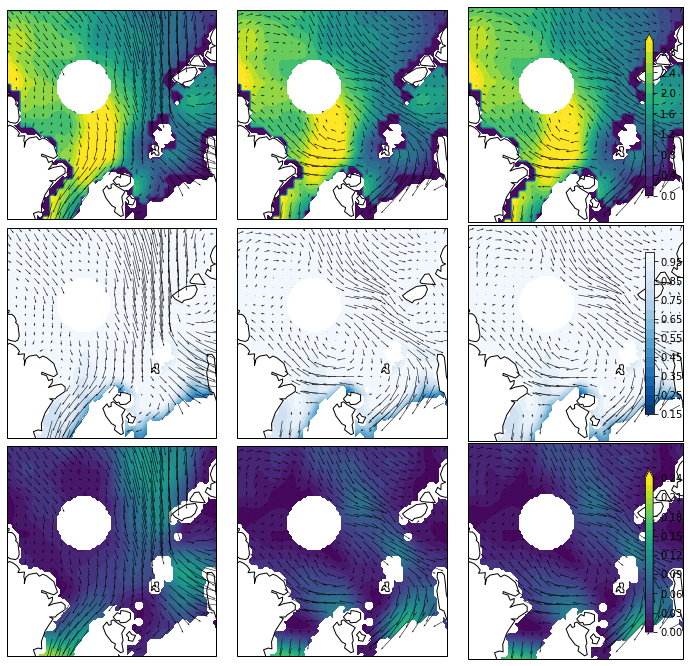

In [412]:
tlevels = np.arange(0,3.2,0.2)
clevels = np.arange(0.15,1.05,0.05)
vlevels = np.arange(0,0.25,0.01)
vsc = 0.8
points = [[-30,75],[120,75],[0,90]]
# points = [[0,75],[60,75],[0,86]]
# points = [[-175,72],[-140,68],[-160,86]] ## Beaufort ish
lims = GV.lims_from_lonlat(points,for_extent = True)
#### plot Velocity (velocity grid)
f = plt.figure(figsize=(12, 12))
for ns in range(3):
    xv,yv = G2Gplocal.rg_vecs(Uslices[ns],Vslices[ns])
    ax = f.add_subplot(3,3,ns+1,projection=m)
#     ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
    ax.set_extent(lims,m)
    ### THICKNESS
    s = ax.contourf(GV.xpts,GV.ypts,Tslices[ns],levels = tlevels,extend='max')
    ax.quiver(Gplocal.xpts,Gplocal.ypts,xv,yv,scale = vsc)
    ax.add_feature(cfeature.COASTLINE)
    if ns ==2: plt.colorbar(s,  pad=-0.18,shrink= 0.75);
#     break
     
    ax = f.add_subplot(3,3,ns+4,projection=m)
#     ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
    ax.set_extent(lims,m)
    ### CONC
    s = ax.contourf(GV.xpts,GV.ypts,Cslices[ns],levels = clevels,cmap = 'Blues_r')# custom_cmap)
    ax.quiver(Gplocal.xpts,Gplocal.ypts,xv,yv,scale = vsc)
    ax.add_feature(cfeature.COASTLINE)
    if ns ==2: plt.colorbar(s,  pad=-0.18,shrink= 0.75);
        
    ax = f.add_subplot(3,3,ns+7,projection=m)
#     ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
    ax.set_extent(lims,m)
    ### DRIFT
    s = ax.contourf(GV.xpts,GV.ypts,np.hypot(Uslices[ns],Vslices[ns]),levels = vlevels,extend='max')
    ax.quiver(Gplocal.xpts,Gplocal.ypts,xv,yv,scale = vsc)
    ax.add_feature(cfeature.COASTLINE)
    if ns ==2: plt.colorbar(s,  pad=-0.18,shrink= 0.75);
        

plt.subplots_adjust(hspace=0.01,wspace = 0.1)
plt.show()

/Users/h/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


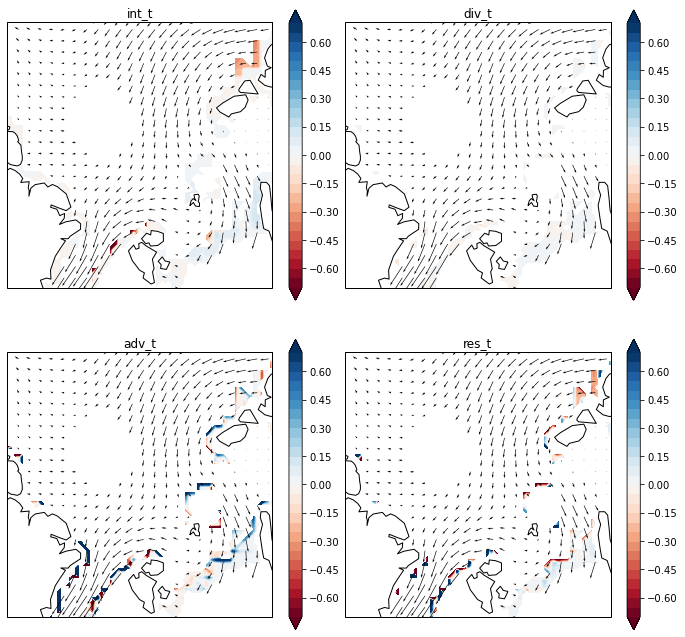

In [314]:
# levels = np.arange(0,1.0,0.25)
# levels = [0.0,0.15,0.5,0.8,0.9,0.95,0.97,0.98,0.985,0.99,0.995,1.0]
# levels = np.arange(-1.3,1.35,0.05)
lmax = 0.7
levels = np.arange(-lmax,lmax+0.05,0.05)
bud_scale = nsecs
vsc = 1.3
#### plot concentration (vel grid)
f = plt.figure(figsize=( 12,12))
for ns,var in enumerate(['int_t','div_t','adv_t','res_t']):
    xv,yv = G2Gplocal.rg_vecs(hist['U'].mean(),hist['V'].mean())
    ax = f.add_subplot(2,2,ns+1,projection=m)
    ax.set_extent(lims,m)
#     ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
    # s = ax.contourf(Gthk.xpts,Gthk.ypts,Tslices[0],levels = levels)
    s = ax.contourf(GV.xpts,GV.ypts,hist[var].total()*bud_scale,levels = levels,
                    cmap = plt.cm.RdBu,extend='both')
#     s = ax.pcolormesh(GV.xptp,GV.yptp,hist[var].total()*bud_scale,cmap = plt.cm.RdBu)
    ax.quiver(Gplocal.xpts,Gplocal.ypts,xv,yv,scale = vsc)
    ax.add_feature(cfeature.COASTLINE)
    plt.colorbar(s,shrink=0.9)
    ax.set_title(var)
    

plt.subplots_adjust(wspace=0.02,hspace=0.02)
plt.show()

/Users/h/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


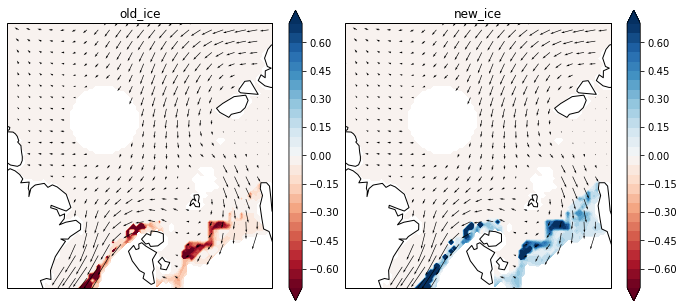

In [315]:
# levels = np.arange(0,1.0,0.25)
# levels = [0.0,0.15,0.5,0.8,0.9,0.95,0.97,0.98,0.985,0.99,0.995,1.0]
# levels = np.arange(-1.3,1.35,0.05)
lmax = 0.7
levels = np.arange(-lmax,lmax+0.05,0.05)
bud_scale = nsecs
vsc = 1.3
#### plot concentration (vel grid)
f = plt.figure(figsize=( 12,12))
for ns,var in enumerate(['old_ice','new_ice']):
    xv,yv = G2Gplocal.rg_vecs(hist['U'].mean(),hist['V'].mean())
    ax = f.add_subplot(2,2,ns+1,projection=m)
    ax.set_extent(lims,m)
#     ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
    # s = ax.contourf(Gthk.xpts,Gthk.ypts,Tslices[0],levels = levels)
    s = ax.contourf(GV.xpts,GV.ypts,hist[var].total()*bud_scale,levels = levels,
                    cmap = plt.cm.RdBu,extend='both')
#     s = ax.pcolormesh(GV.xptp,GV.yptp,hist[var].total()*bud_scale,cmap = plt.cm.RdBu)
    ax.quiver(Gplocal.xpts,Gplocal.ypts,xv,yv,scale = vsc)
    ax.add_feature(cfeature.COASTLINE)
    plt.colorbar(s,shrink=0.9)
    ax.set_title(var)
    

plt.subplots_adjust(wspace=0.02,hspace=0.02)
plt.show()

In [797]:
## f = A - B
## sig_f^2 = sig_A^2 + sig_B^2 - 2 sig_AB

## f = A + B
## sig_f^2 = sig_A^2 + sig_B^2 + 2 sig_AB

## f = AB
## sig_f^2 = f[ (sig_A/A)^2 + (sig_B/B)^2 + 2 sig_AB/AB ]

## SPLIT RIGHT UP TO GET COV VALUES AT ALL STAGES
## deal with sig at all stages (not sig^2)

def div_V_sig(vol,vol_sig,G,cor_dvdx = 0.97):
    signal1 = (vol[2:,1:-1]-vol[:-2,1:-1])/(2*G.xdist[1:-1,1:-1])
    signal2 = (vol[1:-1,2:]-vol[1:-1,:-2])/(2*G.ydist[1:-1,1:-1])
    
    divv1_sig2 = vol_sig[2:,1:-1]**2 + vol_sig[:-2,1:-1]**2 \
               - 2*cor_dvdx*vol_sig[2:,1:-1]*vol_sig[:-2,1:-1]
    divv2_sig2 = vol_sig[1:-1,2:]**2 + vol_sig[1:-1,:-2]**2 \
               - 2*cor_dvdx*vol_sig[1:-1,2:]*vol_sig[1:-1,:-2]
    
    divv1_sig2 = divv1_sig2/(2*G.xdist[1:-1,1:-1])**2
    divv2_sig2 = divv2_sig2/(2*G.ydist[1:-1,1:-1])**2
    
    return signal1,signal2,np.sqrt(divv1_sig2),np.sqrt(divv2_sig2)

def adv_comp_sig(U,V,U_sig,V_sig,
                 div_Vol1,div_Vol2,div_Vol1_sig,div_Vol2_sig,
                 G,cor_sigUdivV = 0.0):
    signal1 = U[1:-1,1:-1]*divVol1
    signal2 = V[1:-1,1:-1]*divVol2
    
    Usig_norm = U_sig[1:-1,1:-1]/U[1:-1,1:-1]
    Vsig_norm = V_sig[1:-1,1:-1]/V[1:-1,1:-1]
    dVol1sig_norm = div_Vol1_sig/div_Vol1
    dVol2sig_norm = div_Vol2_sig/div_Vol2
    
    adv1_sig = signal1**2*(Usig_norm**2 + dVol1sig_norm**2 + 2*cor_sigUdivV*Usig_norm*dVol1sig_norm)
    adv2_sig = signal2**2*(Vsig_norm**2 + dVol2sig_norm**2 + 2*cor_sigUdivV*Vsig_norm*dVol2sig_norm)
#     adv1_sig = signal1*(U_sig[1:-1,1:-1]/U[1:-1,1:-1]**2 + div_Vol1_sig/div_Vol1**2\
#              + 2*cor_sigUdivV)
#     adv2_sig = signal2*(U_sig[1:-1,1:-1]/U[1:-1,1:-1]**2 + div_Vol2_sig/div_Vol2**2 + 2*cor_sigUdivV)
    
    return signal1,signal2,np.sqrt(adv1_sig),np.sqrt(adv2_sig)

def adv_sig(adv1,adv2,adv1_sig,adv2_sig,cor_adv1adv2 = 0.0):
    signal = adv1+adv2
    
    adv_sig = adv1_sig**2 + adv2_sig**2 + 2*cor_adv1adv2*adv1_sig*adv2_sig
    
    return signal,np.sqrt(adv_sig)


def grd_U_comp_sig(U,V,U_sig,V_sig,G,cor_dUdx = 0.98):

    signal1 = (U[2:,1:-1]-U[:-2,1:-1])/(2*G.xdist[1:-1,1:-1])
    signal2 = (V[1:-1,2:]-V[1:-1,:-2])/(2*G.ydist[1:-1,1:-1])
    
    divU1_sig2 = U_sig[2:,1:-1]**2 + U_sig[:-2,1:-1]**2\
               - 2*cor_dUdx*U_sig[2:,1:-1]*U_sig[:-2,1:-1]
    divU2_sig2 = V_sig[1:-1,2:]**2 + V_sig[1:-1,:-2]**2\
               - 2*cor_dUdx*V_sig[1:-1,2:]*V_sig[1:-1,:-2]
    
    divU1_sig2 = divU1_sig2/(2*G.xdist[1:-1,1:-1])**2
    divU2_sig2 = divU2_sig2/(2*G.ydist[1:-1,1:-1])**2
    
    return signal1,signal2,np.sqrt(divU1_sig2),np.sqrt(divU2_sig2)

def grd_U_sig(grdU,grdV,grdU_sig,grdV_sig,G,cor_grdU12 = 0.0):

    signal1 = grdU + grdV
    
    grdV_tot_sig = grdU_sig**2 + grdV_sig**2 + 2*cor_grdU12*grdU_sig*grdV_sig
    
    return signal1,np.sqrt(grdV_tot_sig)

def div_sig(Vol,Vol_sig,grdU,grdUsig,cor_VolgrdU = 0.0):
    
    signal1 = Vol[1:-1,1:-1]*grdU
    
    Vol_sig_norm  = Vol_sig[1:-1,1:-1]/Vol[1:-1,1:-1]
    grdU_sig_norm = grdUsig/grdU
    
    div_sig = signal1**2*(Vol_sig_norm**2 + grdU_sig_norm**2 \
            + 2*cor_VolgrdU*Vol_sig_norm*grdU_sig_norm)
    
    return signal1, np.sqrt(div_sig)

# ### all these require a dimensional uncertainty estimate ("sig" NOT sig^2)
# def advection_sig(U,V,Vol,U_sig,V_sig,Vol_sig,G,cov_divV = 0.45):
#     signal1 = -V[1:-1,1:-1]*(
#         (Vol[1:-1,2:]-Vol[1:-1,:-2])/(2*G.ydist[1:-1,1:-1]))
#     signal2 = -U[1:-1,1:-1]*(
#         (Vol[2:,1:-1]-Vol[:-2,1:-1])/(2*G.xdist[1:-1,1:-1]))
    
#     err_divV1 = Vol_sig[1:-1,2:]**2 + Vol_sig[1:-1,:-2]**2 - 2*cov_dVdt
#     err_divV2 = Vol_sig[2:,1:-1]**2 + Vol_sig[:-2,1:-1]**2 - 2*cov_dVdt
    
#     return np.pad(advtemp,((1,1),(1,1)),'constant',constant_values = np.nan)

# def divergence_sig(U,V,Vol,G):
#     divtemp=-Vol[1:-1,1:-1]*(
#         (V[1:-1,2:]-V[1:-1,:-2])/(2*G.ydist[1:-1,1:-1])) \
#            -Vol[1:-1,1:-1]*(
#         (U[2:,1:-1]-U[:-2,1:-1])/(2*G.xdist[1:-1,1:-1]))
#     return np.pad(divtemp,((1,1),(1,1)),'constant',constant_values = np.nan)


# def intensification_sig(Vols,Vols_sig,nsecs,cov_dVdt = 0.49):
#     ## sig_f^2 = sig_A^2 + sig_B^2 - 2 sig_AB
#     signal = (Vols[2,:,:]-Vols[0,:,:])/(2*nsecs)
#     err_2 = Vols_sig[2,:,:]**2 + Vols_sig[0,:,:]**2 - 2*cov_dVdt
#     return signal,err_2/(2*nsecs)**2
# # import grid_set as gs
